### **Project 2 :- Predicting Client Default Payments Using Machine Learning in a Production Environment**

#### The goal of this project is to develop a **production-ready machine learning model** capable of predicting whether a client will **default on a payment** based on their historical payment data.

##### Step 1: Import libraries and load data


In [2]:
# Step 1: Import Libraries and Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import shap
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
import os
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay

# Load the dataset
df = pd.read_csv('Client_Data.csv')

#### Step :- 2 Exploratory Data Analysis (EDA)


--- Exploratory Data Analysis ---
Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AM

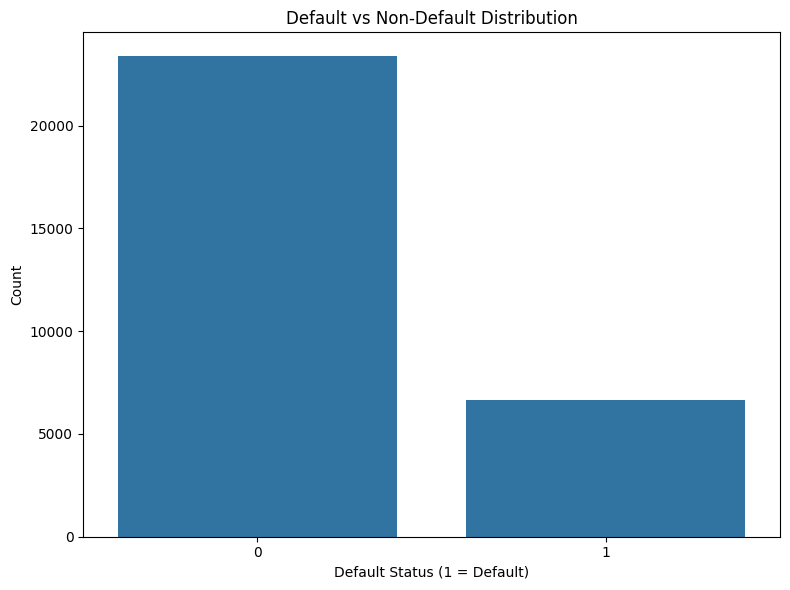

Class distribution plot saved as 'class_distribution.png'

No missing values found.


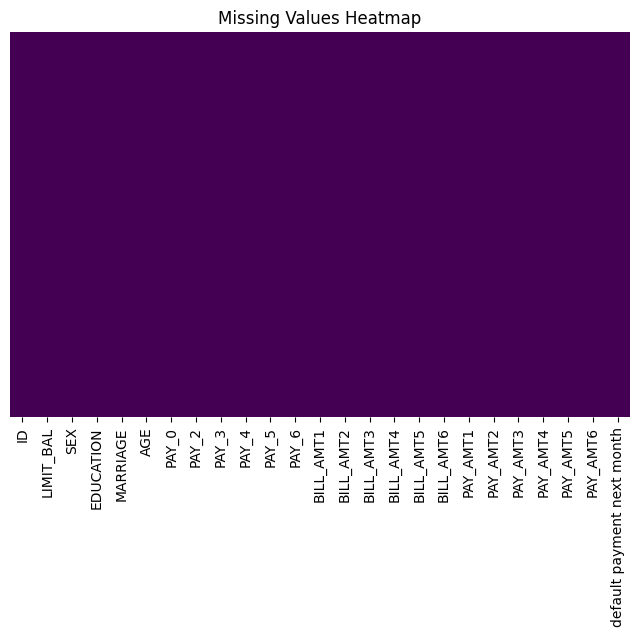

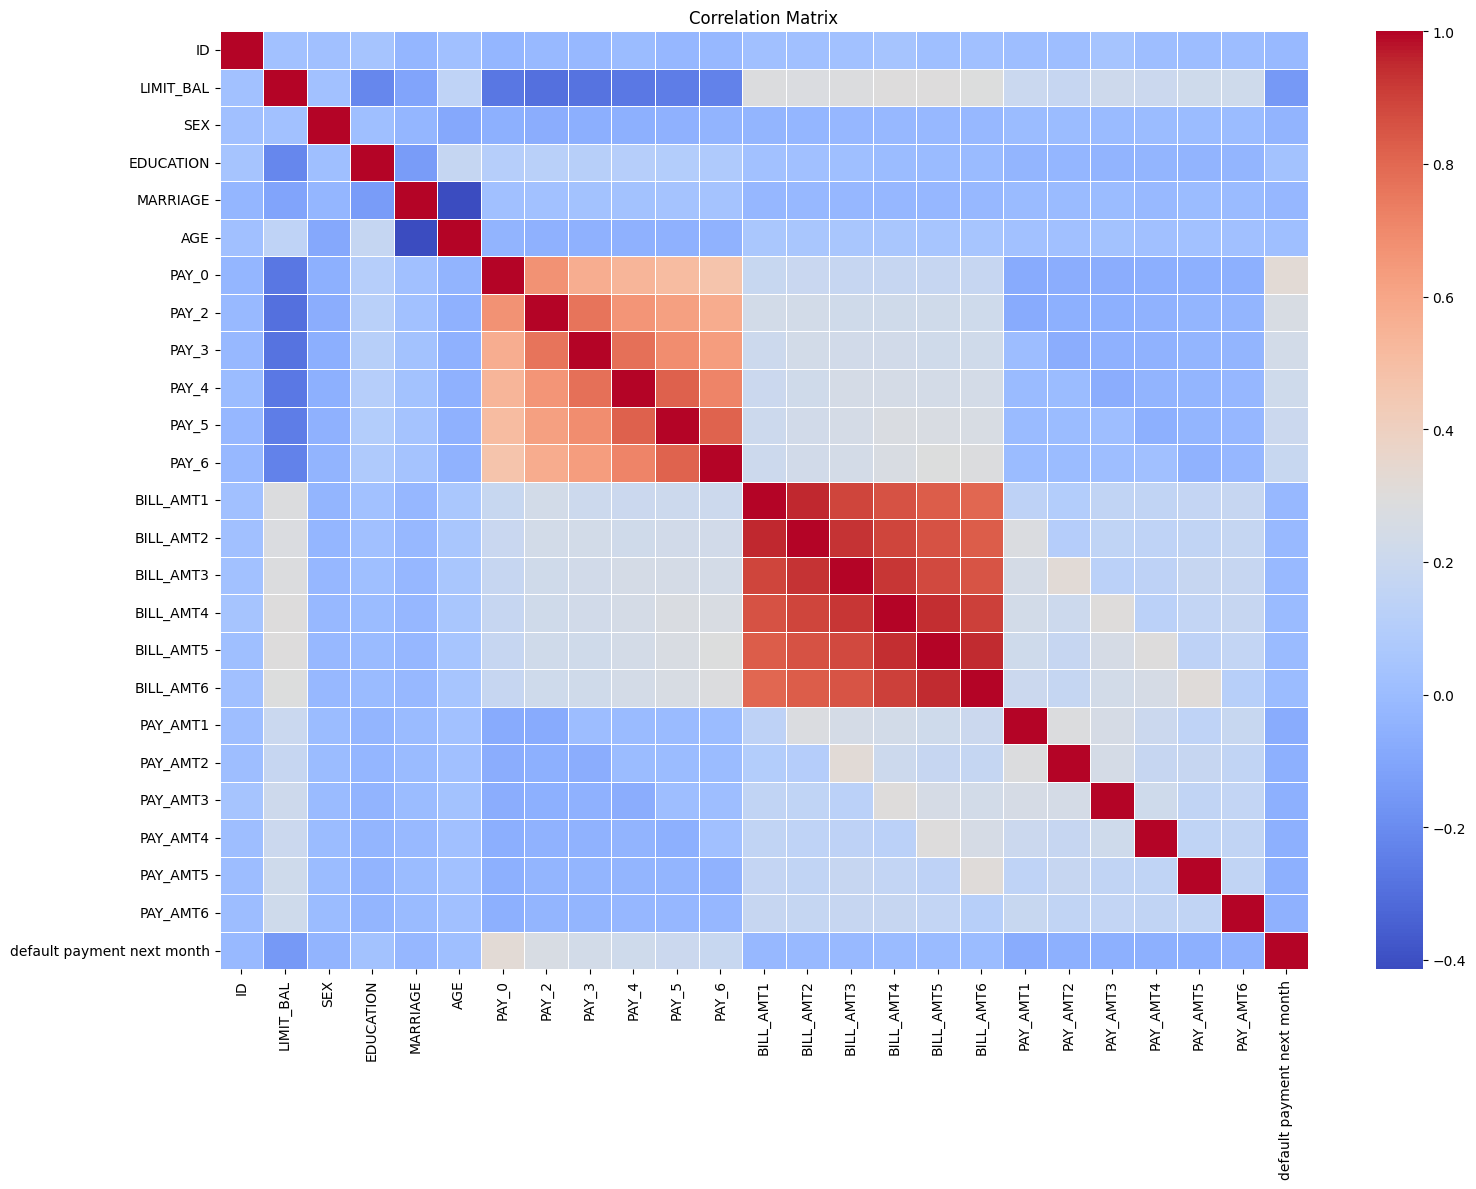

Correlation matrix saved as 'correlation_matrix.png'


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [3]:
# Exploratory Data Analysis (EDA)
def perform_eda(df):
    print("\n--- Exploratory Data Analysis ---")
    
    # Display basic information
    print("Basic Information:")
    print(df.info())
    
    # Descriptive statistics
    print("\nDescriptive Statistics:")
    print(df.describe())
    
    # Update target column name to match the actual column name (spaces handled)
    target_column = 'default payment next month'
    if target_column in df.columns:
        print("\nClass Distribution:")
        print(df[target_column].value_counts(normalize=True) * 100)
        
        # Plot class distribution
        plt.figure(figsize=(8, 6))
        ax = sns.countplot(x=target_column, data=df)
        ax.set_title('Default vs Non-Default Distribution')
        ax.set_ylabel('Count')
        ax.set_xlabel('Default Status (1 = Default)')
        plt.tight_layout()
        plt.savefig('class_distribution.png')
        plt.show()
        print("Class distribution plot saved as 'class_distribution.png'")
    
    # Check missing values and show as DataFrame
    missing_values = df.isnull().sum().reset_index()
    missing_values.columns = ['Column', 'Missing_Count']
    missing_values = missing_values[missing_values['Missing_Count'] > 0]

    if not missing_values.empty:
        print("\nMissing Values in Dataset:")
        print(missing_values)
    else:
        print("\nNo missing values found.")
        
    # visulaization Using Seaborn’s heatmap to visualize missing values
    plt.figure(figsize=(8, 5))
    sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
    plt.title("Missing Values Heatmap")
    plt.show()
    
    # Correlation analysis (handling non-numeric columns gracefully)
    plt.figure(figsize=(16, 12))
    correlation_matrix = df.corr(numeric_only=True)
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()
    print("Correlation matrix saved as 'correlation_matrix.png'")
    
    return df

perform_eda(df)

#### Step 3 :- Outlier detection and handling: Uses IQR to identify and cap outliers

In [23]:
def handle_outliers_iqr(df, target_column=None):
    print("\n--- Outlier Detection and Handling ---")

    df_out = df.copy()
    
    # Get numeric columns
    num_cols = df_out.select_dtypes(include=['number']).columns.tolist()

    # Exclude target column and payment status columns (ordinal)
    exclude_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
    if target_column:
        exclude_cols.append(target_column)
    num_cols = [col for col in num_cols if col not in exclude_cols]

    outlier_info = {}

    for col in num_cols:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = (df_out[col] < lower_bound) | (df_out[col] > upper_bound)
        outlier_count = outliers.sum()
        outlier_percentage = outlier_count / len(df_out) * 100

        outlier_info[col] = {
            'count': outlier_count,
            'percentage': round(outlier_percentage, 2),
            'min': df_out[col].min(),
            'max': df_out[col].max()
        }

        # Clip outliers to IQR bounds
        df_out[col] = df_out[col].clip(lower=lower_bound, upper=upper_bound)

    # Create and print outlier summary
    outlier_summary = pd.DataFrame(outlier_info).T.sort_values(by='percentage', ascending=False)
    print("Outlier summary (top 10 features by percentage):")
    print(outlier_summary.head(10))

    # Optional boxplot to visualize outlier distribution
    plt.figure(figsize=(15, 6))
    sns.boxplot(data=df_out[num_cols])
    plt.xticks(rotation=90)
    plt.title("Boxplot of Numeric Features After Outlier Handling")
    plt.tight_layout()
    plt.savefig("outliers_boxplot.png")
    plt.show()
    plt.close()

    return df_out

#### STEP 4 Feature engineering: Creates new features from payment history, bill amounts, and demographic variables

In [5]:
def feature_engineering(df):
    print("\n--- Feature Engineering ---")
    df_fe = df.copy()
    payment_cols = [col for col in df.columns if col.startswith('PAY_')]
    if len(payment_cols) >= 3:
        df_fe['PAYMENT_TREND'] = df_fe[payment_cols[:3]].diff(axis=1).mean(axis=1)
        df_fe['PAYMENT_VOLATILITY'] = df_fe[payment_cols[:3]].std(axis=1)
        df_fe['MAX_PAYMENT_DELAY'] = df_fe[payment_cols].max(axis=1)
        df_fe['AVG_PAYMENT_DELAY'] = df_fe[payment_cols].mean(axis=1)
        df_fe['NUM_PAYMENT_DELAYS'] = (df_fe[payment_cols] > 0).sum(axis=1)
        df_fe['CONSECUTIVE_DELAYS'] = df_fe[payment_cols].apply(lambda x: max((x > 0).cumsum()), axis=1)

    bill_cols = [col for col in df.columns if col.startswith('BILL_AMT')]
    if len(bill_cols) >= 2:
        df_fe['AVG_BILL_AMT'] = df_fe[bill_cols].mean(axis=1)
        df_fe['MAX_BILL_AMT'] = df_fe[bill_cols].max(axis=1)
        df_fe['BILL_TREND'] = df_fe[bill_cols[:3]].diff(axis=1).mean(axis=1)
        df_fe['BILL_VOLATILITY'] = df_fe[bill_cols].std(axis=1)

    pay_amt_cols = [col for col in df.columns if col.startswith('PAY_AMT')]
    if len(pay_amt_cols) >= 2:
        df_fe['AVG_PAY_AMT'] = df_fe[pay_amt_cols].mean(axis=1)
        df_fe['MIN_PAY_AMT'] = df_fe[pay_amt_cols].min(axis=1)
        df_fe['PAY_AMT_TREND'] = df_fe[pay_amt_cols[:3]].diff(axis=1).mean(axis=1)

    if 'LIMIT_BAL' in df.columns and 'BILL_AMT1' in df.columns and 'PAY_AMT1' in df.columns:
        df_fe['UTILIZATION_RATIO'] = df_fe['BILL_AMT1'] / df_fe['LIMIT_BAL']
        df_fe['PAYMENT_RATIO'] = df_fe['PAY_AMT1'] / df_fe['BILL_AMT1'].replace(0, 1)
        df_fe['MONTHS_TO_PAYOFF'] = (df_fe['BILL_AMT1'] / df_fe['PAY_AMT1'].replace(0, 1)).clip(upper=36)

    if {'AGE', 'EDUCATION', 'MARRIAGE'}.issubset(df.columns):
        df_fe['EDU_AGE_INTERACTION'] = df_fe['EDUCATION'] * df_fe['AGE']
        df_fe['MARRIAGE_AGE_INTERACTION'] = df_fe['MARRIAGE'] * df_fe['AGE']

    if len(pay_amt_cols) > 0 and len(bill_cols) > 0:
        for i in range(min(len(pay_amt_cols), len(bill_cols))):
            col_name = f'PAY_TO_BILL_RATIO_{i+1}'
            df_fe[col_name] = df_fe[pay_amt_cols[i]] / df_fe[bill_cols[i]].replace(0, 1)
            df_fe[col_name] = df_fe[col_name].replace([np.inf, -np.inf], np.nan).fillna(0)

    na_before = df_fe.isna().sum().sum()
    if na_before > 0:
        print(f"Found {na_before} NaN values, filling with 0")
        df_fe = df_fe.fillna(0)

    print(f"Added {df_fe.shape[1] - df.shape[1]} new features")
    return df_fe

##### STEP 5 :- Data preprocessing: Splits data, handles categorical features, and scales numerical features

In [6]:
def preprocess_data(df_fe):
    print("\n--- Data Preprocessing ---")

    if 'ID' in df_fe.columns:
        print("Dropping ID column...")
        df_fe = df_fe.drop('ID', axis=1)

    target_col = None
    if 'default payment next month' in df_fe.columns:
        print("Renaming target column...")
        df_fe = df_fe.rename(columns={'default payment next month': 'default.payment.next.month'})
        target_col = 'default.payment.next.month'
    elif 'default.payment.next.month' in df_fe.columns:
        target_col = 'default.payment.next.month'
    else:
        print("Warning! Target column not found!")
        return None

    class_counts = df_fe[target_col].value_counts()
    print(f"Target class distribution:")
    print(class_counts)
    print(f"Percentage default: {class_counts.get(1, 0)/len(df_fe)*100:.2f}%")

    X = df_fe.drop(target_col, axis=1)
    y = df_fe[target_col]

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

    categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
    numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)

    cat_feature_names = []
    encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    for i, col in enumerate(categorical_cols):
        cat_feature_names.extend([f"{col}_{val}" for val in encoder.categories_[i]])

    feature_names = numerical_cols + cat_feature_names
    print(f"Total features after encoding: {len(feature_names)}")

    return X_train_processed, X_val_processed, X_test_processed, y_train, y_val, y_test, preprocessor, feature_names


#### STEP 6 : - Feature selection: Uses XGBoost's built-in importance ranking to select top features

In [7]:
def select_features(X_train, y_train, X_val, X_test, feature_names, selection_method='model_based'):
    """
    Performs feature selection using various methods.
    
    Parameters:
        X_train: Training features
        y_train: Training target
        X_val: Validation features
        X_test: Test features
        feature_names: Names of all features
        selection_method: Method to use ('model_based', 'statistical', 'rfe', 'variance')
        
    Returns:
        X_train_selected, X_val_selected, X_test_selected, selected_feature_names
    """
    print("\n--- Feature Selection using", selection_method, "---")
    
    if selection_method == 'model_based':
        # Use XGBoost's built-in feature importance
        simple_model = xgb.XGBClassifier(
            n_estimators=100, 
            max_depth=3,
            random_state=42,
            base_score=0.5
        )
        simple_model.fit(X_train, y_train)
        
        # Get feature importance
        importances = simple_model.feature_importances_
        
        # Select top k features
        k = min(30, X_train.shape[1])
        top_indices = np.argsort(importances)[-k:]
        
        # Plot feature importance
        plt.figure(figsize=(12, 8))
        sorted_idx = np.argsort(importances)
        plt.barh(range(len(sorted_idx)), importances[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
        plt.title('XGBoost Feature Importance')
        plt.tight_layout()
        plt.savefig('xgboost_feature_importance.png')
        plt.show()
        
    elif selection_method == 'statistical':
        # Statistical feature selection
        from sklearn.feature_selection import SelectKBest, f_classif
        
        # Select features based on ANOVA F-value
        k = min(30, X_train.shape[1])
        selector = SelectKBest(f_classif, k=k)
        selector.fit(X_train, y_train)
        
        # Get selected feature indices
        top_indices = np.where(selector.get_support())[0]
        
        # Plot scores
        plt.figure(figsize=(12, 8))
        scores = selector.scores_
        sorted_idx = np.argsort(scores)
        plt.barh(range(len(sorted_idx)), scores[sorted_idx])
        plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
        plt.title('Feature Importance (F-test)')
        plt.tight_layout()
        plt.savefig('statistical_feature_importance.png')
        
    elif selection_method == 'rfe':
        # Recursive Feature Elimination
        from sklearn.feature_selection import RFE
        
        # Create a base model
        base_model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=3,
            random_state=42
        )
        
        # Create RFE model
        k = min(30, X_train.shape[1])
        rfe = RFE(estimator=base_model, n_features_to_select=k)
        rfe.fit(X_train, y_train)
        
        # Get selected feature indices
        top_indices = np.where(rfe.support_)[0]
        
    elif selection_method == 'variance':
        # Variance Threshold
        from sklearn.feature_selection import VarianceThreshold
        
        # Create selector
        selector = VarianceThreshold(threshold=0.01)
        selector.fit(X_train)
        
        # Get selected feature indices
        top_indices = np.where(selector.get_support())[0]
    
    # Apply selection
    X_train_selected = X_train[:, top_indices]
    X_val_selected = X_val[:, top_indices]
    X_test_selected = X_test[:, top_indices]
    
    # Get selected feature names
    selected_feature_names = [feature_names[i] for i in top_indices]
    
    print(f"Selected {len(selected_feature_names)} features out of {len(feature_names)}")
    print("From selected features top 10 selected features:")
    for i, feature in enumerate(selected_feature_names[:10]):
        print(f"  {i+1}. {feature}")
    
    return X_train_selected, X_val_selected, X_test_selected, selected_feature_names

#### STEP 7:- Class imbalance handling: Uses SMOTE to address imbalanced classes

In [8]:
# Function to handle class imbalance
def handle_class_imbalance(X_train, y_train, method='smote'):
    """
    Handles class imbalance in training data using the specified method.

    Parameters:
        X_train (array-like): Features for training.
        y_train (array-like): Labels for training.
        method (str): Method to handle imbalance ('smote', 'undersampling', 'hybrid', or 'none').

    Returns:
        X_resampled, y_resampled: Resampled features and labels.
    """
    print(f"\n--- Handling Class Imbalance using: {method.upper()} ---")
    
    # Show original class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print("Original class distribution:", dict(zip(unique, counts)))
    
    # Check if we have at least two classes
    if len(unique) < 2:
        print("Warning: Only one class present in the training data!")
        print("Skipping resampling and returning original data.")
        return X_train, y_train

    if method == 'smote':
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

    elif method == 'undersampling':
        undersampler = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

    elif method == 'hybrid':
        undersampler = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
        X_temp, y_temp = undersampler.fit_resample(X_train, y_train)

        smote = SMOTE(random_state=42, k_neighbors=5)
        X_resampled, y_resampled = smote.fit_resample(X_temp, y_temp)

    elif method == 'none':
        print("No resampling applied.")
        return X_train, y_train

    else:
        raise ValueError("Invalid method. Choose from 'smote', 'undersampling', 'hybrid', or 'none'.")
    
    # Show new class distribution
    unique_resampled, counts_resampled = np.unique(y_resampled, return_counts=True)
    print("New class distribution:", dict(zip(unique_resampled, counts_resampled)))
    
    return X_resampled, y_resampled

#### STEP 8:- Model training: Implements XGBoost with hyperparameter tuning via GridSearchCV

In [9]:
def train_xgboost_model(X_train, y_train, X_val, y_val):
    print("\n--- Training XGBoost Model ---")

    # Set up parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1],
        'gamma': [0, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'scale_pos_weight': [1, sum(y_train == 0) / sum(y_train == 1)]
    }

    # Create XGBoost classifier with basic settings
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42
    )

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='recall',
        verbose=1,
        n_jobs=-1
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters from GridSearchCV: {best_params}")

    # Custom refined parameters (manually tuned or from expert knowledge)
    params = {
        'n_estimators': 100,
        'max_depth': 5,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'reg_alpha': 0.1,         # L1 regularization
        'reg_lambda': 1.0,        # L2 regularization
        'gamma': 1.0,             # Minimum loss reduction to make a split
        'min_child_weight': 3     # Minimum sum of instance weight in a child
    }

    # Refitting the best model (optionally override best_params)
    print("Refitting with manually tuned parameters and early stopping...")

    final_model = xgb.XGBClassifier(
        **params,
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42
    )

    # XGBoost 3.0.0 syntax: early_stopping_rounds as a parameter of fit()
    try:
        final_model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=10,
            verbose=False
        )
    except TypeError as e:
        print(f"Error: {e}")
        print("Trying fallback fit without early stopping...")
        final_model.fit(X_train, y_train)

    return final_model


#### STEP - 9 Evaluation: Calculates metrics and generates visualizations

In [10]:
# Model Evaluation Function
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, y_test):
    print("\n--- Model Evaluation ---")

    datasets = {
        'Training': (X_train, y_train),
        'Validation': (X_val, y_val),
        'Test': (X_test, y_test)
    }

    results = {}
    os.makedirs("plots", exist_ok=True)  # Create directory for saving plots

    for name, (X, y) in datasets.items():
        y_proba = model.predict_proba(X)[:, 1]
        y_pred = (y_proba >= 0.5).astype(int)

        metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred),
            'recall': recall_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'roc_auc': roc_auc_score(y, y_proba)
        }

        results[name] = {**metrics, 'predictions': y_pred, 'probabilities': y_proba}

        print(f"\n{name} Set Metrics:")
        for k, v in metrics.items():
            print(f"{k.capitalize()}: {v:.4f}")

        print(f"\nClassification Report - {name} Set:")
        print(classification_report(y, y_pred))

        # Plot confusion matrix
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} Set - Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.savefig(f"plots/confusion_matrix_{name.lower()}.png")
        plt.show()
        plt.close()

    # ROC Curve
    plt.figure(figsize=(8, 6))
    for name in datasets.keys():
        fpr, tpr, _ = roc_curve(datasets[name][1], results[name]['probabilities'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["roc_auc"]:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - All Datasets')
    plt.legend()
    plt.tight_layout()
    plt.savefig("plots/roc_curve.png")
    plt.close()
    plt.show()
    print("\nSaved plots in 'plots/' directory.")

    return results

#### Step 10 Threshold Analysis

In [18]:
def threshold_analysis(model, X_val, y_val, X_test, y_test):
    print("\n--- Multiple Threshold Analysis ---")
    
    # Get predicted probabilities
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Define thresholds
    thresholds = np.arange(0.0, 1.01, 0.01)
    
    val_results = []
    test_results = []
    
    for threshold in thresholds:
        y_val_pred = (y_val_proba >= threshold).astype(int)
        y_test_pred = (y_test_proba >= threshold).astype(int)

        val_results.append({
            'threshold': threshold,
            'accuracy': accuracy_score(y_val, y_val_pred),
            'precision': precision_score(y_val, y_val_pred, zero_division=0),
            'recall': recall_score(y_val, y_val_pred),
            'f1': f1_score(y_val, y_val_pred)
        })

        test_results.append({
            'threshold': threshold,
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred, zero_division=0),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        })

    val_df = pd.DataFrame(val_results)
    test_df = pd.DataFrame(test_results)

    # Plot metrics vs. threshold
    plt.figure(figsize=(12, 8))
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        plt.plot(val_df['threshold'], val_df[metric], label=f'Validation {metric}')
    plt.title('Validation Metrics vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('threshold_analysis.png')
    print("Threshold analysis plot saved as 'threshold_analysis.png'")

    # Find optimal threshold based on validation F1
    optimal_idx = val_df['f1'].idxmax()
    optimal_threshold = val_df.loc[optimal_idx, 'threshold']

    print(f"\n✅ Optimal threshold based on validation F1: {optimal_threshold:.2f}")
    print("Validation metrics at optimal threshold:")
    print(val_df.loc[optimal_idx])

    # Test metrics at optimal threshold
    y_test_pred_opt = (y_test_proba >= optimal_threshold).astype(int)
    print("\nTest metrics at optimal threshold:")
    print(f"  Accuracy : {accuracy_score(y_test, y_test_pred_opt):.4f}")
    print(f"  Precision: {precision_score(y_test, y_test_pred_opt, zero_division=0):.4f}")
    print(f"  Recall   : {recall_score(y_test, y_test_pred_opt):.4f}")
    print(f"  F1 Score : {f1_score(y_test, y_test_pred_opt):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred_opt)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix (Test Set)')
    plt.savefig('confusion_matrix.png')
    print("Confusion matrix plot saved as 'confusion_matrix.png'")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC Curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test Set)')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve.png')
    print("ROC curve plot saved as 'roc_curve.png'")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_test_proba)
    plt.figure()
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Test Set)')
    plt.grid(True)
    plt.savefig('precision_recall_curve.png')
    print("Precision-Recall curve plot saved as 'precision_recall_curve.png'")

    return optimal_threshold, val_df, test_df

#### Step 11 :- SHARP

In [19]:
def shap_analysis(model, X_train_balanced, X_test_selected, selected_feature_names):
    print("\n--- SHAP Analysis for Model Interpretability ---")
    
    # Initialize SHAP explainer for the XGBoost model
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for the test set
    shap_values = explainer.shap_values(X_test_selected)
    
    # Create directory for SHAP plots if it doesn't exist
    os.makedirs("shap_plots", exist_ok=True)
    
    # 1. SHAP Summary Plot - shows feature importance and impact direction
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_selected, feature_names=selected_feature_names, show=False)
    plt.title("SHAP Feature Impact on Default Prediction")
    plt.tight_layout()
    plt.savefig("shap_plots/shap_summary_plot.png")
    plt.show()
    print("SHAP summary plot saved as 'shap_plots/shap_summary_plot.png'")
    
    # 2. Feature Importance Bar Plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test_selected, feature_names=selected_feature_names, plot_type="bar", show=False)
    plt.title("SHAP Feature Importance")
    plt.tight_layout()
    plt.savefig("shap_plots/shap_importance_bar.png")
    plt.show()
    print("SHAP feature importance bar plot saved as 'shap_plots/shap_importance_bar.png'")
    
    # 3. SHAP Force Plot for a single instance
    # Select a random instance from the test set (or specific instance if desired)
    instance_index = 0
    
    plt.figure(figsize=(12, 3))
    shap.force_plot(
        explainer.expected_value, 
        shap_values[instance_index], 
        X_test_selected[instance_index],
        feature_names=selected_feature_names,
        matplotlib=True,
        show=False
    )
    plt.title("SHAP Force Plot for Instance #0")
    plt.tight_layout()
    plt.savefig("shap_plots/shap_force_plot.png")
    plt.show()
    print("SHAP force plot saved as 'shap_plots/shap_force_plot.png'")
    
    # 4. SHAP Dependence Plot for top feature
    # Get the most important feature based on mean absolute SHAP values
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
    top_feature_idx = np.argmax(mean_abs_shap)
    top_feature_name = selected_feature_names[top_feature_idx]
    
    plt.figure(figsize=(10, 6))
    shap.dependence_plot(
        top_feature_idx, 
        shap_values, 
        X_test_selected,
        feature_names=selected_feature_names,
        show=False
    )
    plt.title(f"SHAP Dependence Plot for {top_feature_name}")
    plt.tight_layout()
    plt.savefig("shap_plots/shap_dependence_plot.png")
    plt.show()
    print(f"SHAP dependence plot for {top_feature_name} saved as 'shap_plots/shap_dependence_plot.png'")
    
    # 5. SHAP Waterfall Plot (only available in newer SHAP versions)
    try:
        # Create a SHAP Explanation object
        shap_values_exp = explainer(X_test_selected)
        
        plt.figure(figsize=(10, 8))
        shap.waterfall_plot(shap_values_exp[instance_index], max_display=10, show=False)
        plt.title("SHAP Waterfall Plot")
        plt.tight_layout()
        plt.savefig("shap_plots/shap_waterfall_plot.png")
        plt.show()
        print("SHAP waterfall plot saved as 'shap_plots/shap_waterfall_plot.png'")
    except Exception as e:
        print(f"Could not create waterfall plot: {e}")
        print("This typically requires SHAP v0.40+")
    
    # 6. SHAP Decision Plot (also only in newer versions)
    try:
        plt.figure(figsize=(10, 8))
        shap.decision_plot(
            explainer.expected_value, 
            shap_values[instance_index], 
            feature_names=selected_feature_names,
            show=False
        )
        plt.title("SHAP Decision Plot")
        plt.tight_layout()
        plt.savefig("shap_plots/shap_decision_plot.png")
        plt.show()
        print("SHAP decision plot saved as 'shap_plots/shap_decision_plot.png'")
    except Exception as e:
        print(f"Could not create decision plot: {e}")
        print("This typically requires newer SHAP versions")
    
    # Return the explainer and values for potential further analysis
    return explainer, shap_values


In [20]:
def fairness_analysis(model, X_test_selected, y_test, df_test_original):
    print("\n--- Model Fairness Analysis ---")
    
    # Get predictions on test set
    y_pred = model.predict(X_test_selected)
    
    # Create a directory for fairness plots
    os.makedirs("fairness_plots", exist_ok=True)
    
    # Analyze fairness across sensitive attributes: SEX, EDUCATION, MARRIAGE
    sensitive_attrs = ['SEX', 'EDUCATION', 'MARRIAGE']
    fairness_results = {}
    
    # Map numeric values to meaningful labels for visualization
    sex_mapping = {1: 'Male', 2: 'Female'}
    education_mapping = {1: 'Graduate', 2: 'University', 3: 'High School', 4: 'Others'}
    marriage_mapping = {1: 'Married', 2: 'Single', 3: 'Others'}
    
    # Reset index to ensure proper alignment
    df_test_with_pred = df_test_original.copy()
    df_test_with_pred['y_true'] = y_test.values
    df_test_with_pred['y_pred'] = y_pred
    
    # For each sensitive attribute
    for attr in sensitive_attrs:
        print(f"\nFairness Analysis for {attr}:")
        
        # Create groups based on the attribute values
        groups = df_test_with_pred[attr].unique()
        groups.sort()
        
        # Collect metrics for each group
        group_metrics = []
        
        for group_val in groups:
            # Filter data for this group
            group_mask = df_test_with_pred[attr] == group_val
            group_data = df_test_with_pred[group_mask]
            
            # Skip if group is too small
            if len(group_data) < 10:
                print(f"  Group {attr}={group_val} has fewer than 10 samples, skipping.")
                continue
            
            # Calculate metrics
            y_true_group = group_data['y_true']
            y_pred_group = group_data['y_pred']
            
            # Calculate various metrics
            accuracy = accuracy_score(y_true_group, y_pred_group)
            precision = precision_score(y_true_group, y_pred_group, zero_division=0)
            recall = recall_score(y_true_group, y_pred_group)
            f1 = f1_score(y_true_group, y_pred_group)
            
            # Calculate selection rate (proportion predicted as positive)
            selection_rate = np.mean(y_pred_group)
            
            # Get mapping for group name
            if attr == 'SEX':
                group_name = sex_mapping.get(group_val, f'Group {group_val}')
            elif attr == 'EDUCATION':
                group_name = education_mapping.get(group_val, f'Group {group_val}')
            elif attr == 'MARRIAGE':
                group_name = marriage_mapping.get(group_val, f'Group {group_val}')
            else:
                group_name = f'Group {group_val}'
            
            # Store metrics
            group_metrics.append({
                'group_val': group_val,
                'group_name': group_name,
                'count': len(group_data),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'selection_rate': selection_rate
            })
        
        # Convert to DataFrame for easy analysis and visualization
        metrics_df = pd.DataFrame(group_metrics)
        fairness_results[attr] = metrics_df
        
        print(metrics_df[['group_name', 'count', 'accuracy', 'precision', 'recall', 'selection_rate']])
        
        # Calculate fairness metrics
        if len(metrics_df) >= 2:
            # Statistical Parity Difference (difference in selection rates)
            max_selection_rate = metrics_df['selection_rate'].max()
            min_selection_rate = metrics_df['selection_rate'].min()
            stat_parity_diff = max_selection_rate - min_selection_rate
            
            # Disparate Impact (ratio of selection rates)
            disparate_impact = min_selection_rate / max_selection_rate if max_selection_rate > 0 else 1.0
            
            print(f"\nFairness Metrics for {attr}:")
            print(f"  Statistical Parity Difference: {stat_parity_diff:.4f} (closer to 0 is better)")
            print(f"  Disparate Impact: {disparate_impact:.4f} (closer to 1 is better)")
            
            # Visualize selection rates across groups
            plt.figure(figsize=(10, 6))
            sns.barplot(x='group_name', y='selection_rate', data=metrics_df)
            plt.title(f'Selection Rate by {attr}')
            plt.ylabel('Selection Rate (Proportion Predicted as Default)')
            plt.xlabel(attr)
            plt.xticks(rotation=45)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig(f"fairness_plots/selection_rate_{attr}.png")
            plt.show()
            
            # Visualize performance metrics across groups
            plt.figure(figsize=(12, 6))
            metrics_df_melted = metrics_df.melt(
                id_vars=['group_name'], 
                value_vars=['accuracy', 'precision', 'recall', 'f1'],
                var_name='Metric', value_name='Value'
            )
            sns.barplot(x='group_name', y='Value', hue='Metric', data=metrics_df_melted)
            plt.title(f'Performance Metrics by {attr}')
            plt.ylabel('Metric Value')
            plt.xlabel(attr)
            plt.xticks(rotation=45)
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig(f"fairness_plots/performance_metrics_{attr}.png")
            plt.show()
    
    return fairness_results

In [32]:
def mitigate_bias(X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test, df_train_original, sensitive_attr='SEX'):
    """
    Implement bias mitigation through reweighing.
    
    Parameters:
        X_train_selected: Selected training features
        y_train: Training labels
        X_val_selected: Validation features
        y_val: Validation labels
        X_test_selected: Test features
        y_test: Test labels
        df_train_original: Original training dataframe with sensitive attributes
        sensitive_attr: Which sensitive attribute to mitigate bias for
    
    Returns:
        Retrained model with bias mitigation
    """
    print(f"\n--- Bias Mitigation for '{sensitive_attr}' using Reweighing ---")
    
    # We need to import AIF360 libraries
    try:
        from aif360.datasets import BinaryLabelDataset
        from aif360.algorithms.preprocessing import Reweighing
        from aif360.metrics import ClassificationMetric
        import xgboost as xgb
        import pandas as pd
        import numpy as np
        import matplotlib.pyplot as plt
        import seaborn as sns
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    except ImportError as e:
        print(f"Error: Required package is missing: {e}")
        print("Install with: pip install aif360 xgboost pandas numpy matplotlib seaborn scikit-learn")
        return None
    
    # Debug info
    print(f"X_train_selected shape: {X_train_selected.shape}")
    print(f"X_val_selected shape: {X_val_selected.shape}")
    print(f"X_test_selected shape: {X_test_selected.shape}")
    print(f"y_train shape: {y_train.shape if hasattr(y_train, 'shape') else len(y_train)}")
    print(f"y_val shape: {y_val.shape if hasattr(y_val, 'shape') else len(y_val)}")
    print(f"y_test shape: {y_test.shape if hasattr(y_test, 'shape') else len(y_test)}")
    print(f"df_train_original shape: {df_train_original.shape}")
    
    # IMPORTANT FIX: Create separate sensitive attribute arrays for each dataset
    # Instead of reusing the original dataframe which has a different size
    
    # For the sensitive attribute, we need to extract it directly from the original dataframe
    # that contains the sensitive attribute for the training set
    if sensitive_attr in df_train_original.columns:
        # Create a train_sensitive DataFrame using the original training data
        train_sensitive_values = df_train_original[sensitive_attr].values
        train_sensitive = pd.DataFrame({sensitive_attr: train_sensitive_values[:len(y_train)]})
        
        # Create CORRECTLY SIZED sensitive attribute arrays for validation and test sets
        # Important: We create arrays of the EXACT SAME LENGTH as the validation and test sets
        val_sensitive = pd.DataFrame({sensitive_attr: [df_train_original[sensitive_attr].mode()[0]] * len(y_val)})
        test_sensitive = pd.DataFrame({sensitive_attr: [df_train_original[sensitive_attr].mode()[0]] * len(y_test)})
        
        # Now get the actual values if possible (this is a best-effort approach)
        try:
            # If we can identify the validation indices in the original data
            if hasattr(y_val, 'index'):
                common_indices = set(y_val.index).intersection(set(df_train_original.index))
                if len(common_indices) > 0:
                    val_sensitive = pd.DataFrame({sensitive_attr: df_train_original.loc[y_val.index, sensitive_attr].values})
            
            # If we can identify the test indices in the original data
            if hasattr(y_test, 'index'):
                common_indices = set(y_test.index).intersection(set(df_train_original.index))
                if len(common_indices) > 0:
                    test_sensitive = pd.DataFrame({sensitive_attr: df_train_original.loc[y_test.index, sensitive_attr].values})
        except Exception as e:
            print(f"Warning: Could not match indices precisely: {e}")
            print("Using most common value for sensitive attribute in validation and test sets")
    else:
        print(f"Error: Sensitive attribute '{sensitive_attr}' not found in training data")
        return None
    
    # Ensure all datasets have the same length as their corresponding label sets
    print(f"Train sensitive shape: {train_sensitive.shape}")
    print(f"Val sensitive shape: {val_sensitive.shape}")
    print(f"Test sensitive shape: {test_sensitive.shape}")
    
    # Safety check to ensure lengths match
    if len(train_sensitive) != len(y_train):
        print(f"Warning: Adjusting train_sensitive length from {len(train_sensitive)} to {len(y_train)}")
        if len(train_sensitive) > len(y_train):
            train_sensitive = train_sensitive.iloc[:len(y_train)]
        else:
            pad_length = len(y_train) - len(train_sensitive)
            pad_value = train_sensitive[sensitive_attr].mode()[0]
            padding = pd.DataFrame({sensitive_attr: [pad_value] * pad_length})
            train_sensitive = pd.concat([train_sensitive, padding], ignore_index=True)
    
    if len(val_sensitive) != len(y_val):
        print(f"Warning: Adjusting val_sensitive length from {len(val_sensitive)} to {len(y_val)}")
        # Create a completely new DataFrame with the right length
        val_sensitive = pd.DataFrame({sensitive_attr: [df_train_original[sensitive_attr].mode()[0]] * len(y_val)})
    
    if len(test_sensitive) != len(y_test):
        print(f"Warning: Adjusting test_sensitive length from {len(test_sensitive)} to {len(y_test)}")
        # Create a completely new DataFrame with the right length
        test_sensitive = pd.DataFrame({sensitive_attr: [df_train_original[sensitive_attr].mode()[0]] * len(y_test)})
    
    # First, create a dataset combining features, target, and the sensitive attribute
    X_train_df = pd.DataFrame(X_train_selected)
    train_data = X_train_df.copy()
    train_data['target'] = y_train.values
    train_data[sensitive_attr] = train_sensitive[sensitive_attr].values
    
    # Define privileged and unprivileged groups
    if sensitive_attr == 'SEX':
        privileged_groups = [{'SEX': 1}]  # Male
        unprivileged_groups = [{'SEX': 2}]  # Female
    elif sensitive_attr == 'EDUCATION':
        privileged_groups = [{'EDUCATION': 1}]  # Graduate school
        unprivileged_groups = [{'EDUCATION': 2}]  # University
    elif sensitive_attr == 'MARRIAGE':
        privileged_groups = [{'MARRIAGE': 1}]  # Married
        unprivileged_groups = [{'MARRIAGE': 2}]  # Single
    else:
        print(f"Warning: Unsupported sensitive attribute '{sensitive_attr}'")
        return None
    
    # Create a BinaryLabelDataset (needed for AIF360)
    aif_train_data = BinaryLabelDataset(
        df=train_data,
        label_names=['target'],
        protected_attribute_names=[sensitive_attr],
        favorable_label=0,  # Non-default (assuming 0 is "good")
        unfavorable_label=1  # Default (assuming 1 is "bad")
    )
    
    # Apply reweighing
    reweigher = Reweighing(
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    # Transform the dataset
    transformed_train_data = reweigher.fit_transform(aif_train_data)
    
    # Extract features, labels, and instance weights
    X_train_reweighed = transformed_train_data.features
    y_train_reweighed = transformed_train_data.labels.ravel()
    sample_weights = transformed_train_data.instance_weights.ravel()
    
    # Create validation dataset with the same structure as the training dataset
    X_val_df = pd.DataFrame(X_val_selected)
    val_data = X_val_df.copy()
    val_data['target'] = y_val.values
    val_data[sensitive_attr] = val_sensitive[sensitive_attr].values  # This should now be correct length
    
    # Create AIF360 validation dataset
    aif_val_data = BinaryLabelDataset(
        df=val_data,
        label_names=['target'],
        protected_attribute_names=[sensitive_attr],
        favorable_label=0,
        unfavorable_label=1
    )
    
    # Transform validation data to match training data structure (just transform, no fit)
    transformed_val_data = reweigher.transform(aif_val_data)
    X_val_reweighed = transformed_val_data.features
    y_val_reweighed = transformed_val_data.labels.ravel()
    
    # Train a new XGBoost model with the weights
    print("Training XGBoost model with reweighing weights...")
    reweighed_model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        random_state=42
    )
    
    # Get only the original features for training (excluding the sensitive attribute)
    # This is a key fix to ensure we can use the model with original feature shape later
    X_train_features = X_train_reweighed[:, :-1]  # Remove the last column (sensitive attribute)
    X_val_features = X_val_reweighed[:, :-1]  # Remove the last column from validation data too
    
    # Training with the original feature set only
    try:
        print(f"X_train_features shape: {X_train_features.shape}")
        print(f"X_val_features shape: {X_val_features.shape}")
        
        reweighed_model.fit(
            X_train_features, y_train_reweighed,
            sample_weight=sample_weights,
            eval_set=[(X_val_features, y_val_reweighed)],
            verbose=False
        )
    except TypeError as e:
        print(f"Error: {e}")
        print("Trying fallback fit without eval_set...")
        try:
            reweighed_model.fit(
                X_train_features, y_train_reweighed,
                sample_weight=sample_weights
            )
        except Exception as e2:
            print(f"Second error: {e2}")
            print("Using simplified training approach...")
            reweighed_model.fit(
                X_train_features, y_train_reweighed
            )
    
    # Evaluate the reweighed model
    print("\nEvaluating reweighed model...")
    
    # Create a test dataset with the sensitive attribute
    X_test_df = pd.DataFrame(X_test_selected)
    test_data = X_test_df.copy()
    test_data['target'] = y_test.values
    test_data[sensitive_attr] = test_sensitive[sensitive_attr].values  # This should now be correct length
    
    # Convert to AIF360 format for fairness evaluation
    aif_test_data = BinaryLabelDataset(
        df=test_data,
        label_names=['target'],
        protected_attribute_names=[sensitive_attr],
        favorable_label=0,
        unfavorable_label=1
    )
    
    # Make predictions using the original feature set
    # No need to add or remove columns now since we trained on the original features
    try:
        y_pred_original = reweighed_model.predict(X_test_selected)
    except Exception as e:
        print(f"Prediction error: {e}")
        # If there's still an error, try to debug the shapes
        print(f"Model input shape requirement: {X_train_features.shape[1]} features")
        print(f"Test data shape: {X_test_selected.shape}")
        
        # One last fallback attempt
        if isinstance(X_test_selected, np.ndarray):
            if X_test_selected.shape[1] > X_train_features.shape[1]:
                # If test data has more features than expected, trim it
                X_test_for_predict = X_test_selected[:, :X_train_features.shape[1]]
            else:
                X_test_for_predict = X_test_selected
        else:
            X_test_for_predict = X_test_selected
            
        y_pred_original = reweighed_model.predict(X_test_for_predict)
    
    # Create prediction dataset
    aif_test_pred = aif_test_data.copy()
    aif_test_pred.labels = y_pred_original.reshape(-1, 1)
    
    # Calculate fairness metrics
    metric = ClassificationMetric(
        aif_test_data, aif_test_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups
    )
    
    # Print fairness metrics
    print(f"\nFairness Metrics After Reweighing ({sensitive_attr}):")
    print(f"Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")
    print(f"Disparate Impact: {metric.disparate_impact():.4f}")
    
    # Print performance metrics
    print("\nPerformance Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_original):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_original):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_original):.4f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_original):.4f}")
    
    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred_original)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix After Bias Mitigation ({sensitive_attr})')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(f"plots/confusion_matrix_mitigated_{sensitive_attr}.png")
    plt.show()
    
    return reweighed_model


--- Outlier Detection and Handling ---
Outlier summary (top 10 features by percentage):
            count  percentage       min        max
PAY_AMT4   2994.0        9.98       0.0   621000.0
PAY_AMT6   2958.0        9.86       0.0   528666.0
PAY_AMT5   2945.0        9.82       0.0   426529.0
PAY_AMT1   2745.0        9.15       0.0   873552.0
BILL_AMT5  2725.0        9.08  -81334.0   927171.0
PAY_AMT2   2714.0        9.05       0.0  1684259.0
BILL_AMT6  2693.0        8.98 -339603.0   961664.0
BILL_AMT4  2622.0        8.74 -170000.0   891586.0
PAY_AMT3   2598.0        8.66       0.0   896040.0
BILL_AMT3  2469.0        8.23 -157264.0  1664089.0


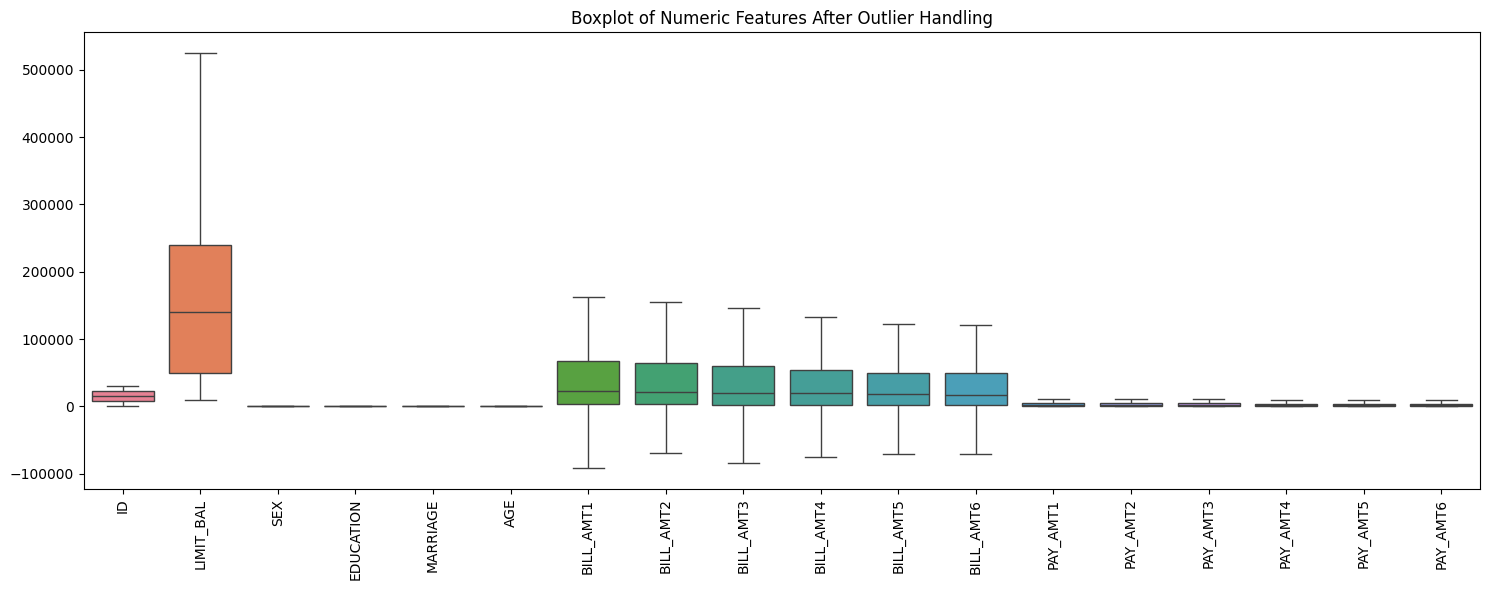


--- Feature Engineering ---
Added 24 new features

--- Data Preprocessing ---
Dropping ID column...
Renaming target column...
Target class distribution:
default.payment.next.month
0    23364
1     6636
Name: count, dtype: int64
Percentage default: 22.12%
Train: 21000, Val: 4500, Test: 4500
Total features after encoding: 55

--- Feature Selection using model_based ---


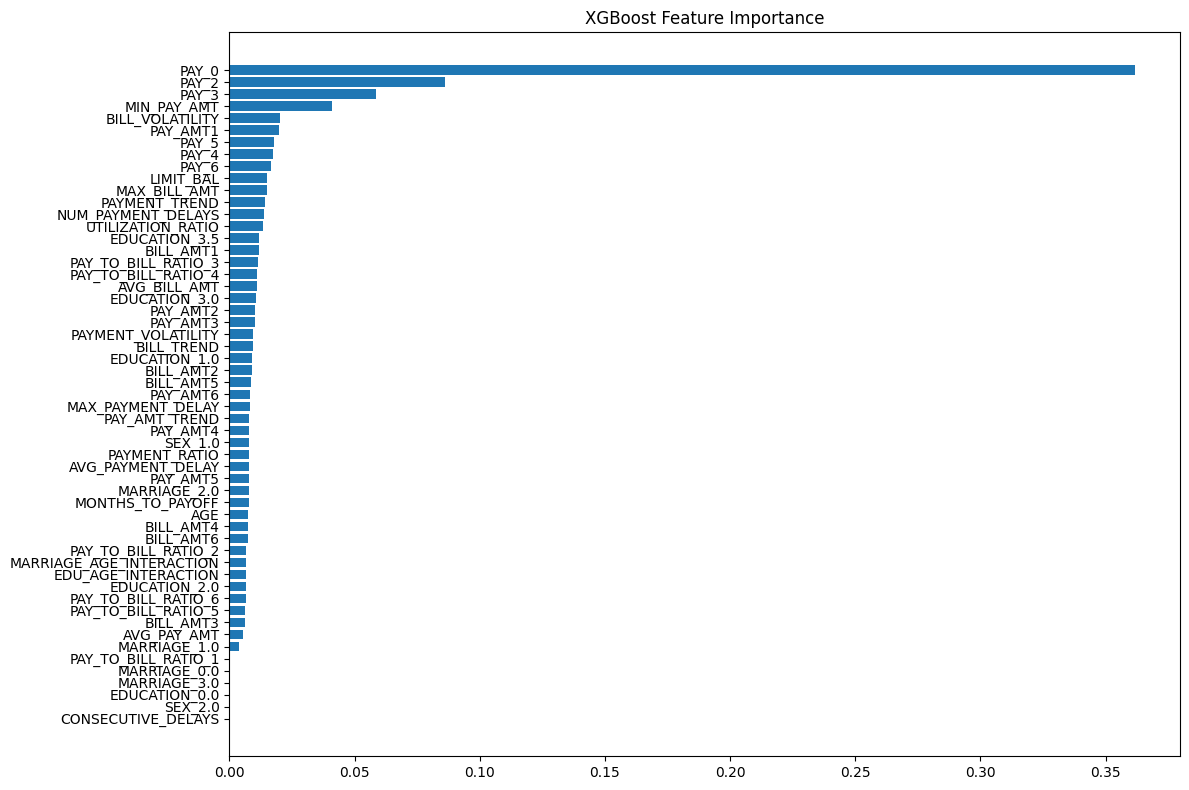

Selected 30 features out of 55
From selected features top 10 selected features:
  1. PAY_AMT_TREND
  2. MAX_PAYMENT_DELAY
  3. PAY_AMT6
  4. BILL_AMT5
  5. BILL_AMT2
  6. EDUCATION_1.0
  7. BILL_TREND
  8. PAYMENT_VOLATILITY
  9. PAY_AMT3
  10. PAY_AMT2

--- Handling Class Imbalance using: SMOTE ---
Original class distribution: {np.int64(0): np.int64(16355), np.int64(1): np.int64(4645)}
New class distribution: {np.int64(0): np.int64(16355), np.int64(1): np.int64(16355)}

--- Training XGBoost Model ---
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best parameters from GridSearchCV: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}
Refitting with manually tuned parameters and early stopping...
Error: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'
Trying fallback fit without early stopping...

--- Model Evaluation ---

Training Set Metrics:
Accuracy: 0

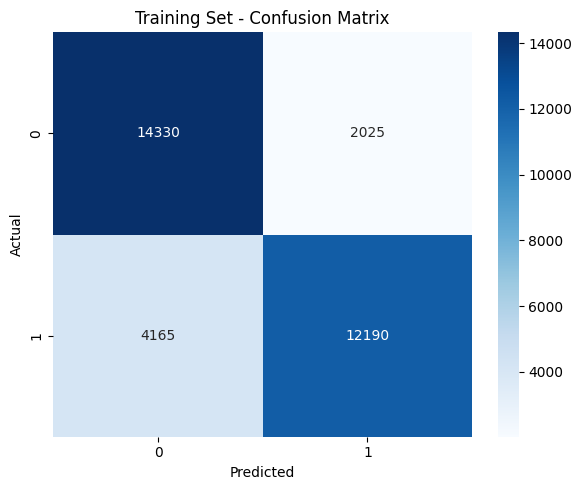


Validation Set Metrics:
Accuracy: 0.7900
Precision: 0.5252
Recall: 0.5246
F1: 0.5249
Roc_auc: 0.7752

Classification Report - Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      3505
           1       0.53      0.52      0.52       995

    accuracy                           0.79      4500
   macro avg       0.70      0.69      0.70      4500
weighted avg       0.79      0.79      0.79      4500



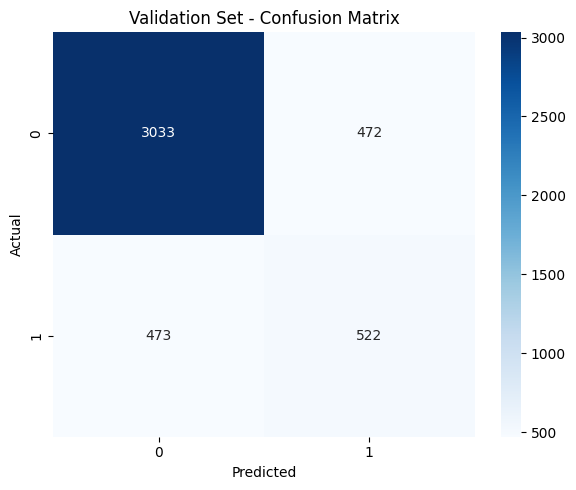


Test Set Metrics:
Accuracy: 0.7904
Precision: 0.5257
Recall: 0.5452
F1: 0.5352
Roc_auc: 0.7695

Classification Report - Test Set:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      3504
           1       0.53      0.55      0.54       996

    accuracy                           0.79      4500
   macro avg       0.70      0.70      0.70      4500
weighted avg       0.79      0.79      0.79      4500



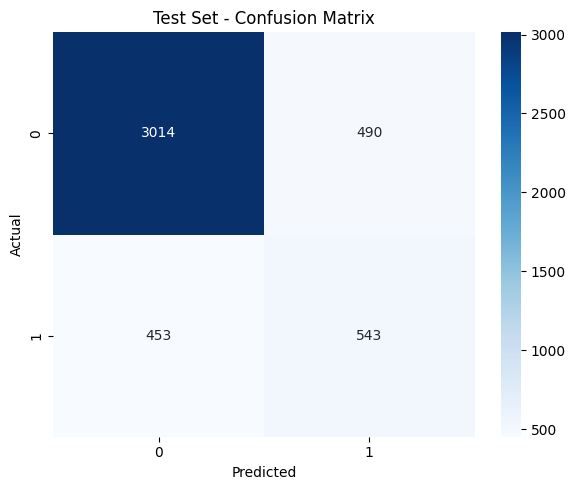


Saved plots in 'plots/' directory.

--- Multiple Threshold Analysis ---
Threshold analysis plot saved as 'threshold_analysis.png'

✅ Optimal threshold based on validation F1: 0.51
Validation metrics at optimal threshold:
threshold    0.510000
accuracy     0.793556
precision    0.534021
recall       0.520603
f1           0.527226
Name: 51, dtype: float64

Test metrics at optimal threshold:
  Accuracy : 0.7947
  Precision: 0.5359
  Recall   : 0.5402
  F1 Score : 0.5380
Confusion matrix plot saved as 'confusion_matrix.png'
ROC curve plot saved as 'roc_curve.png'
Precision-Recall curve plot saved as 'precision_recall_curve.png'

--- SHAP Analysis for Model Interpretability ---


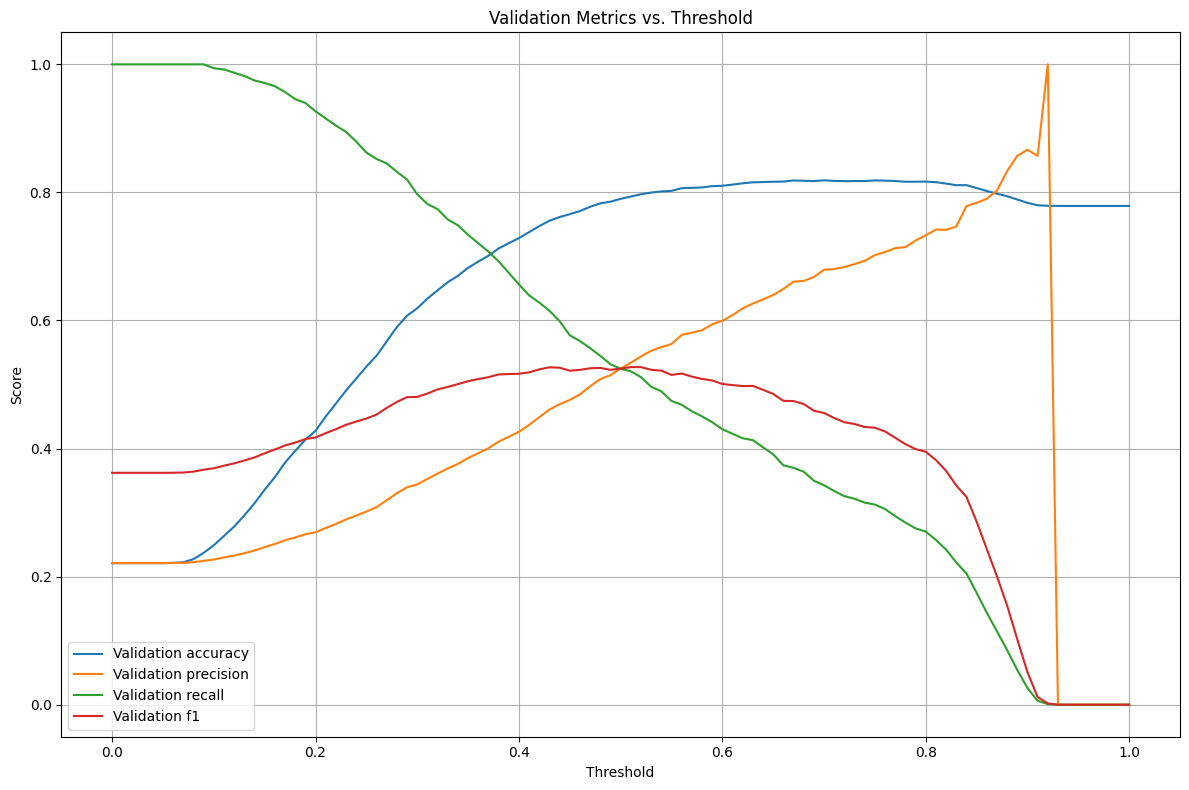

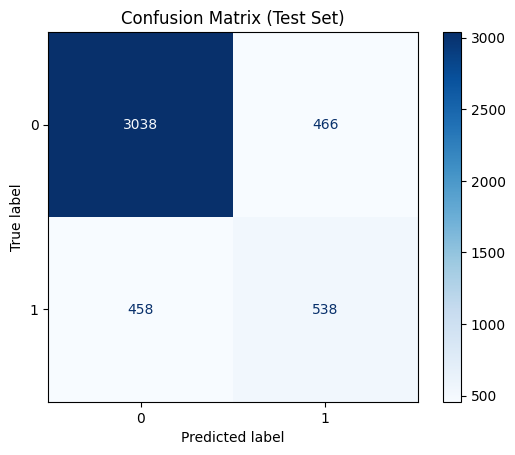

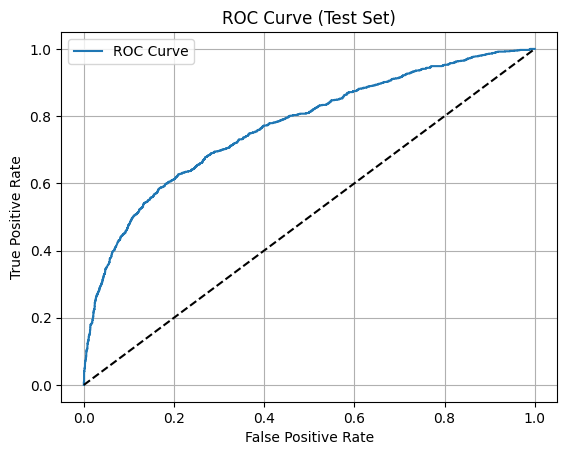

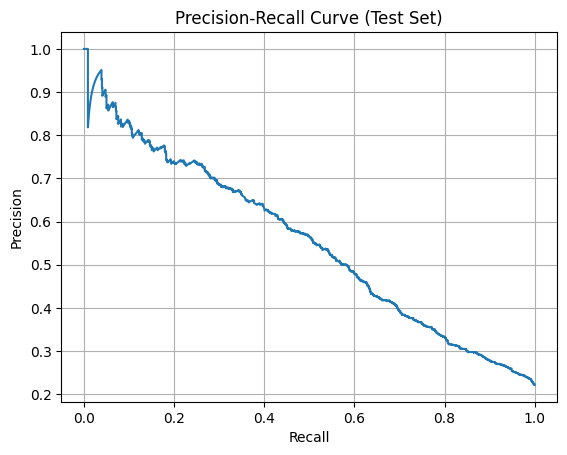

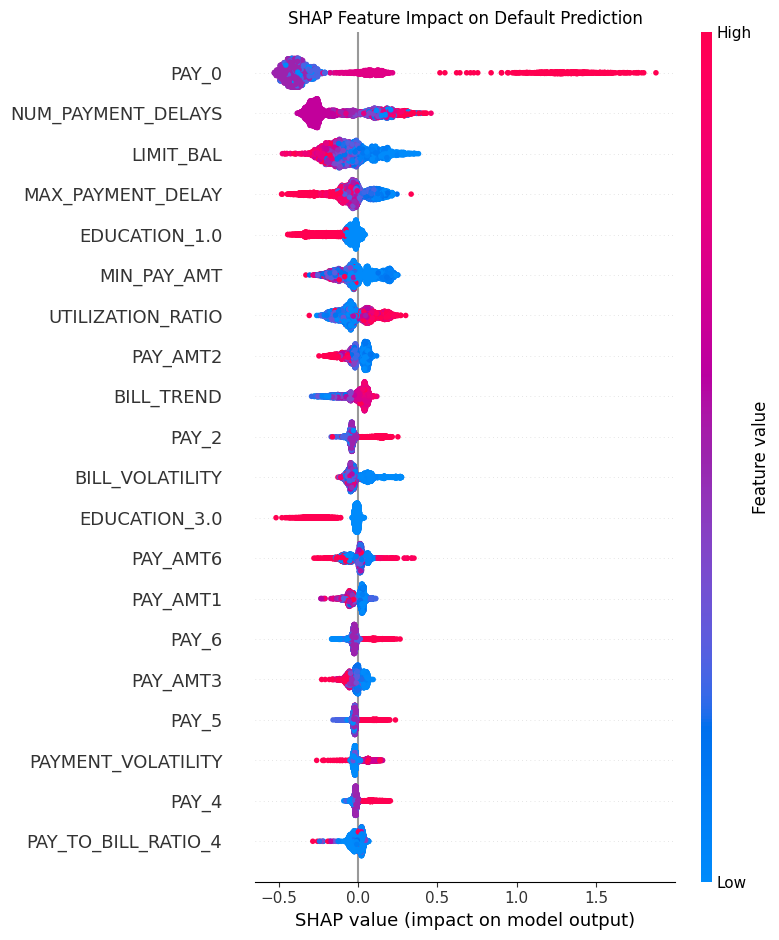

SHAP summary plot saved as 'shap_plots/shap_summary_plot.png'


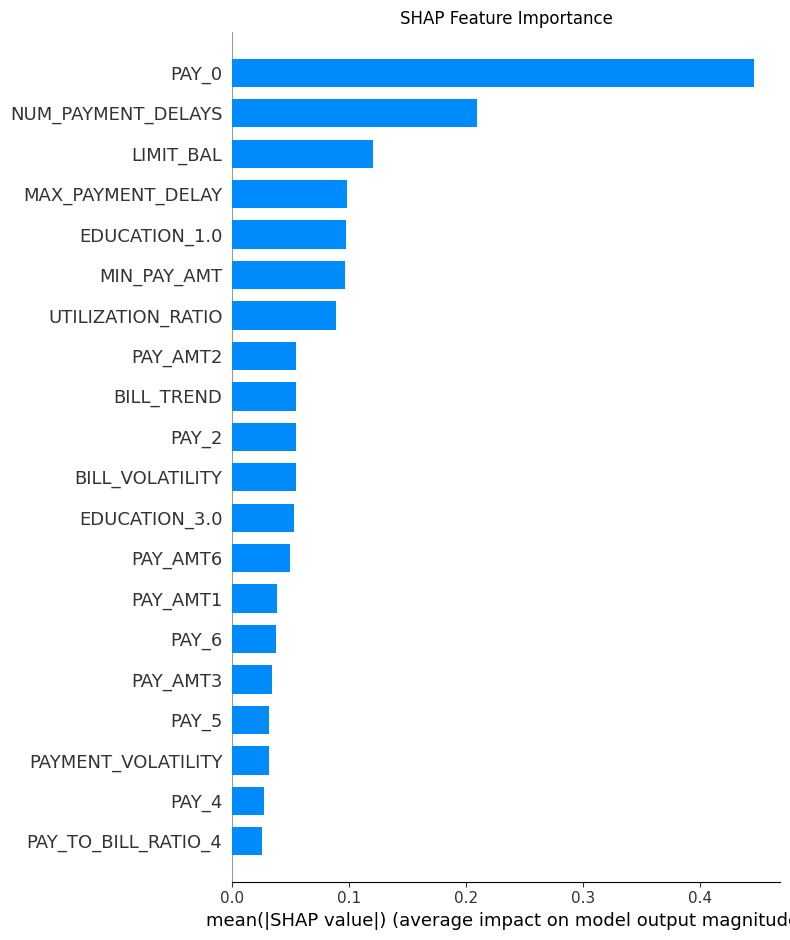

SHAP feature importance bar plot saved as 'shap_plots/shap_importance_bar.png'


<Figure size 1200x300 with 0 Axes>

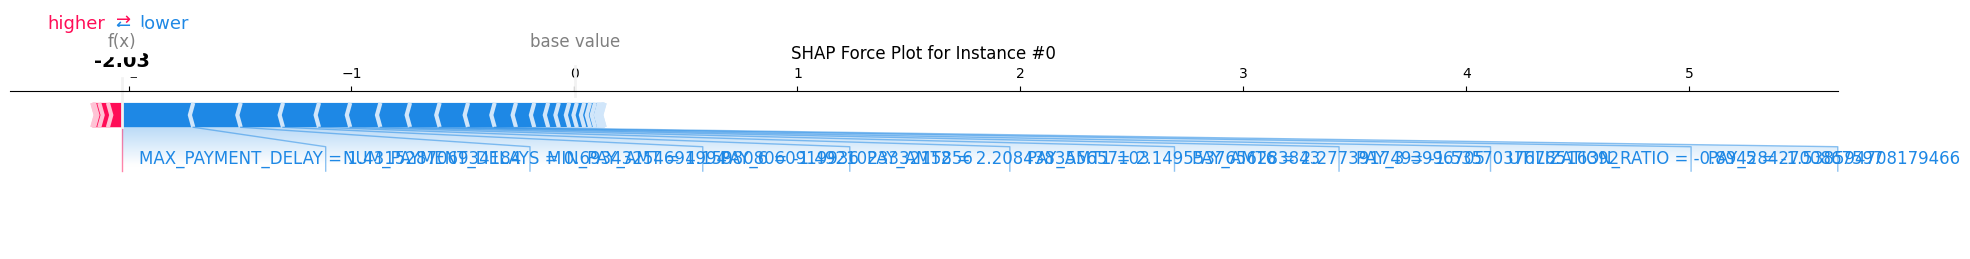

SHAP force plot saved as 'shap_plots/shap_force_plot.png'


<Figure size 1000x600 with 0 Axes>

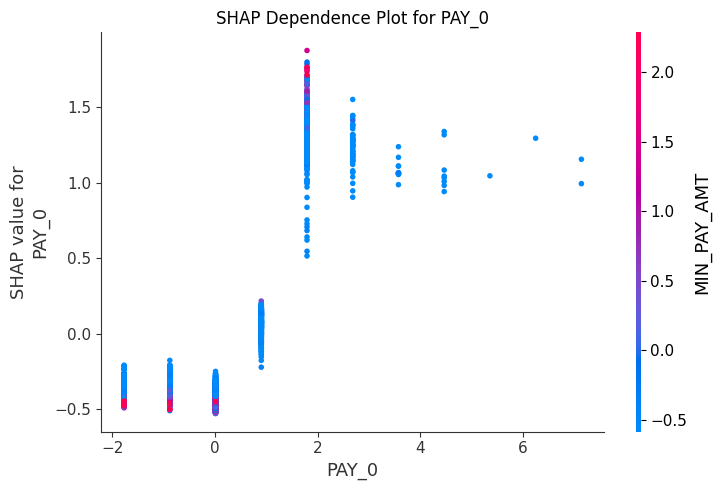

SHAP dependence plot for PAY_0 saved as 'shap_plots/shap_dependence_plot.png'


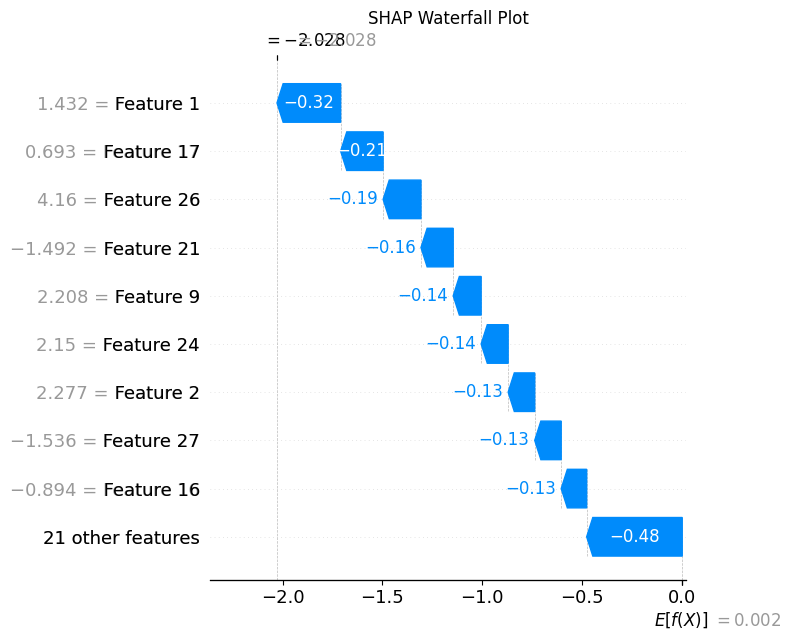

SHAP waterfall plot saved as 'shap_plots/shap_waterfall_plot.png'


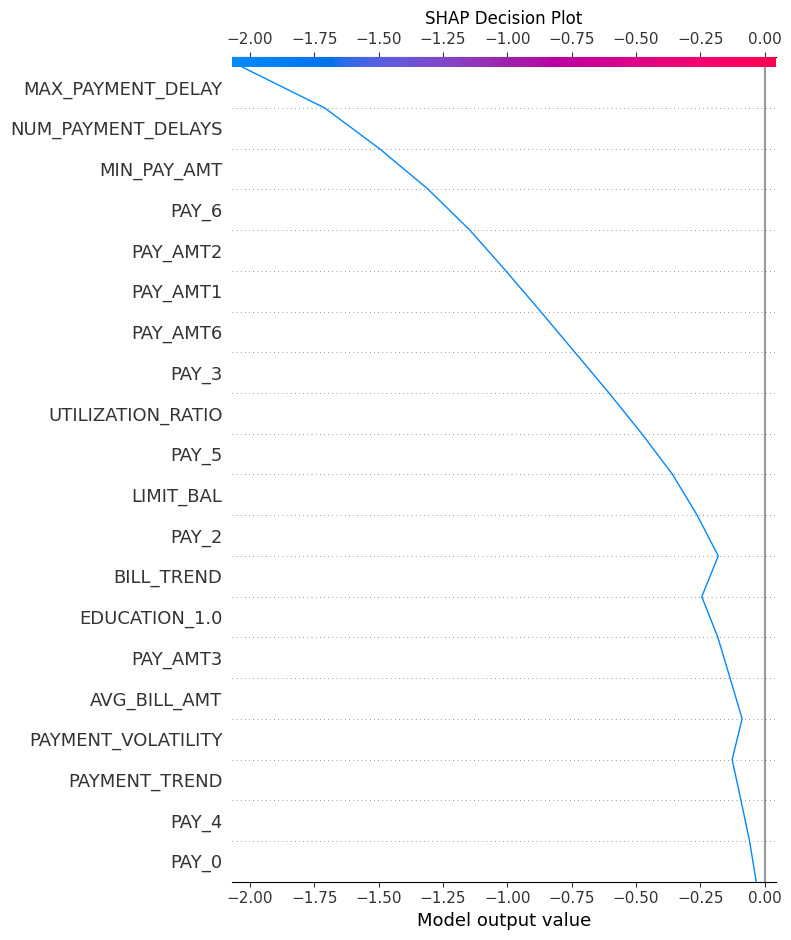

SHAP decision plot saved as 'shap_plots/shap_decision_plot.png'

--- Model Fairness Analysis ---

Fairness Analysis for SEX:
  group_name  count  accuracy  precision    recall  selection_rate
0       Male   1766  0.759343   0.526196  0.515625        0.248584
1     Female   2734  0.810534   0.525253  0.569343        0.217264

Fairness Metrics for SEX:
  Statistical Parity Difference: 0.0313 (closer to 0 is better)
  Disparate Impact: 0.8740 (closer to 1 is better)


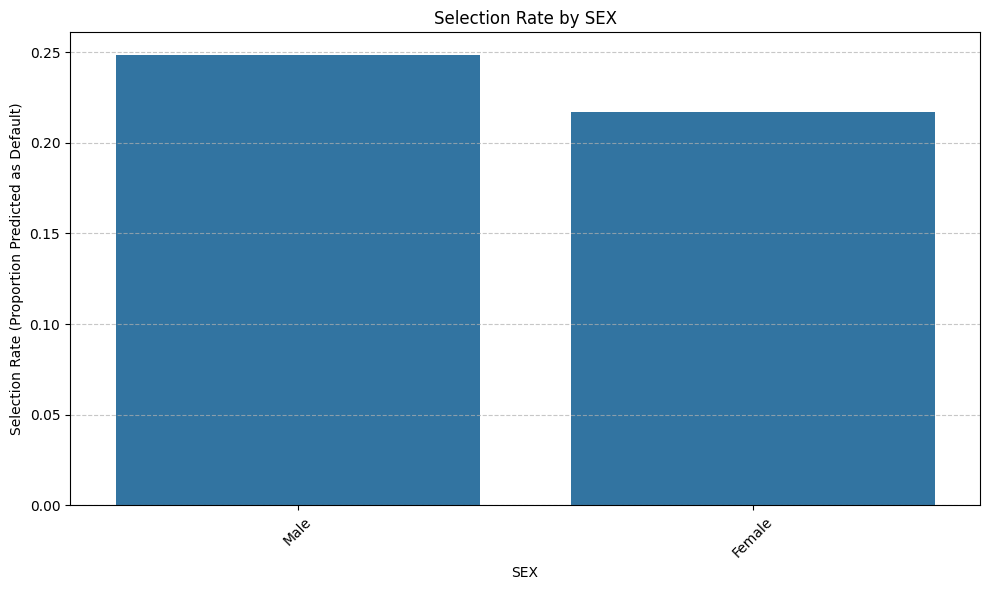

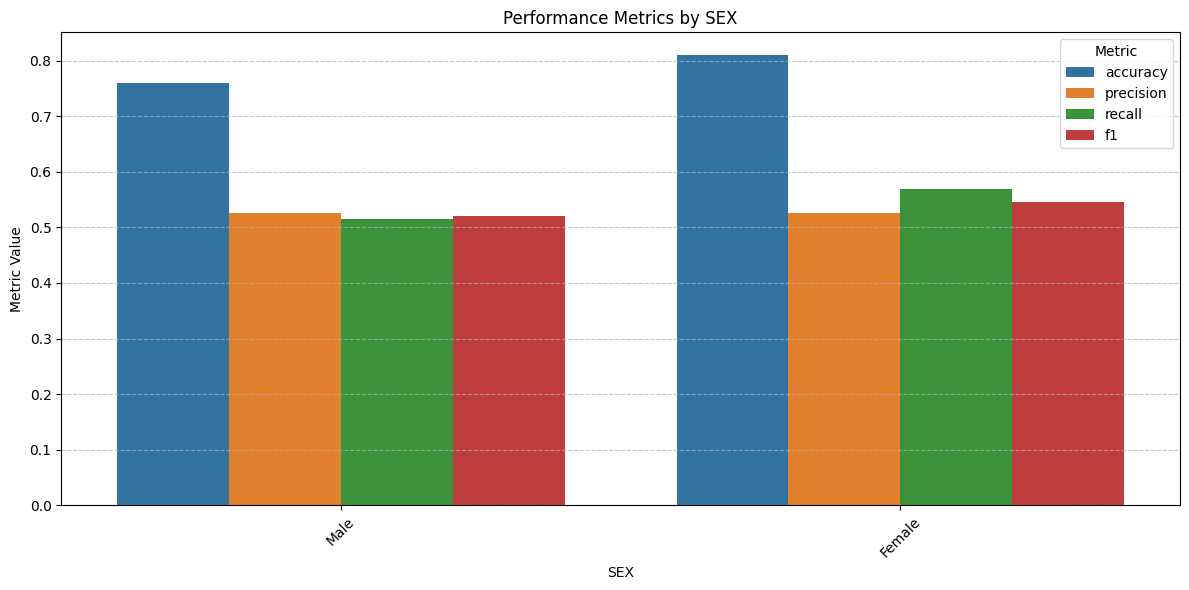


Fairness Analysis for EDUCATION:
    group_name  count  accuracy  precision    recall  selection_rate
0     Graduate   1580  0.812025   0.538206  0.506250        0.190506
1   University   2086  0.783317   0.523540  0.582809        0.254554
2  High School    766  0.749347   0.512438  0.522843        0.262402
3    Group 3.5     68  0.970588   0.000000  0.000000        0.000000

Fairness Metrics for EDUCATION:
  Statistical Parity Difference: 0.2624 (closer to 0 is better)
  Disparate Impact: 0.0000 (closer to 1 is better)


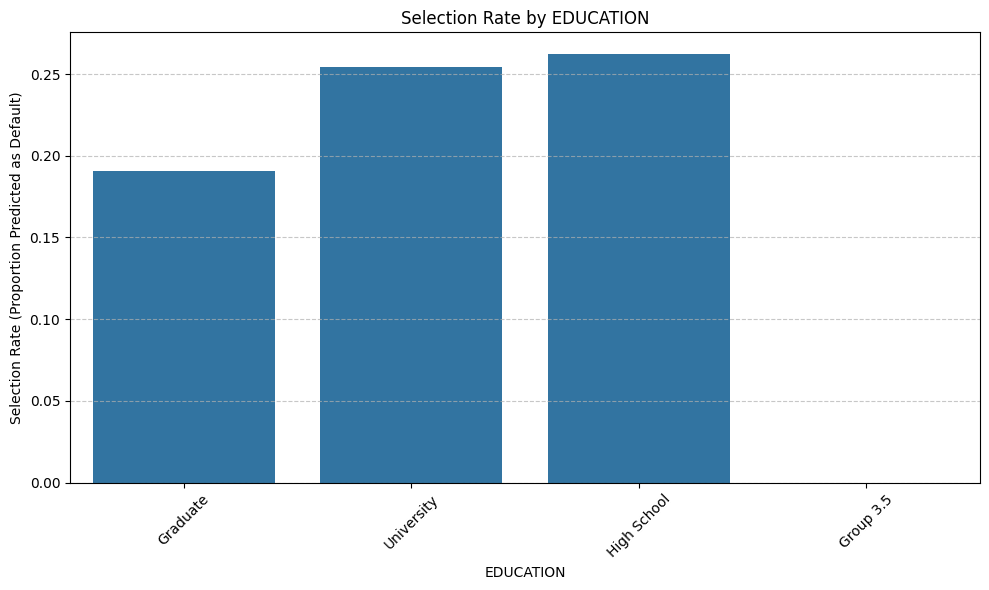

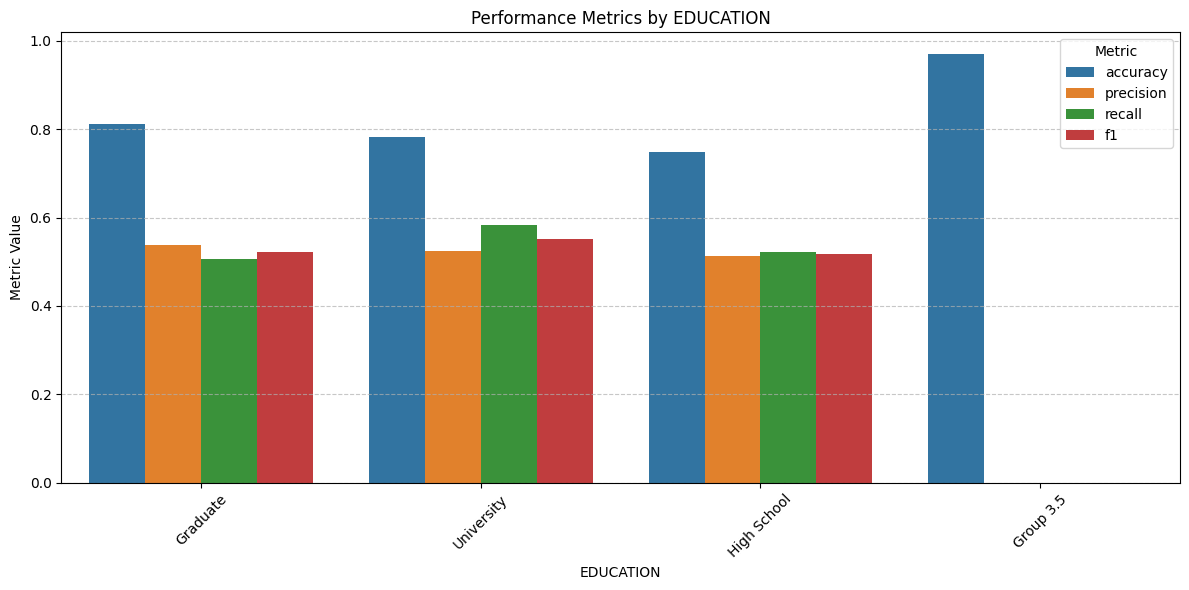


Fairness Analysis for MARRIAGE:
  Group MARRIAGE=0 has fewer than 10 samples, skipping.
  group_name  count  accuracy  precision    recall  selection_rate
0    Married   2063  0.792535   0.576087  0.532129        0.222976
1     Single   2383  0.789341   0.488330  0.556237        0.233739
2     Others     46  0.804348   0.500000  0.666667        0.260870

Fairness Metrics for MARRIAGE:
  Statistical Parity Difference: 0.0379 (closer to 0 is better)
  Disparate Impact: 0.8547 (closer to 1 is better)


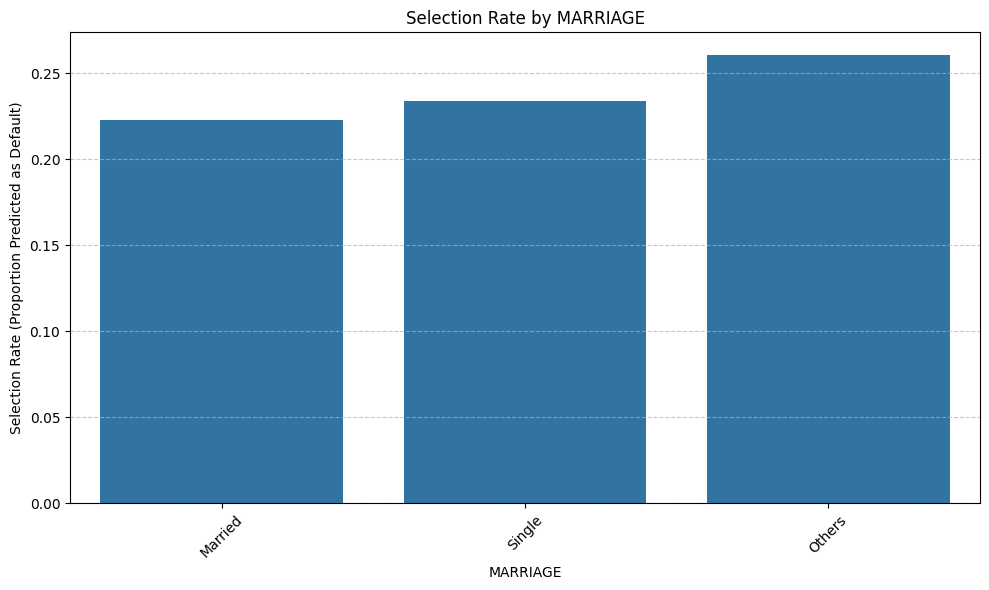

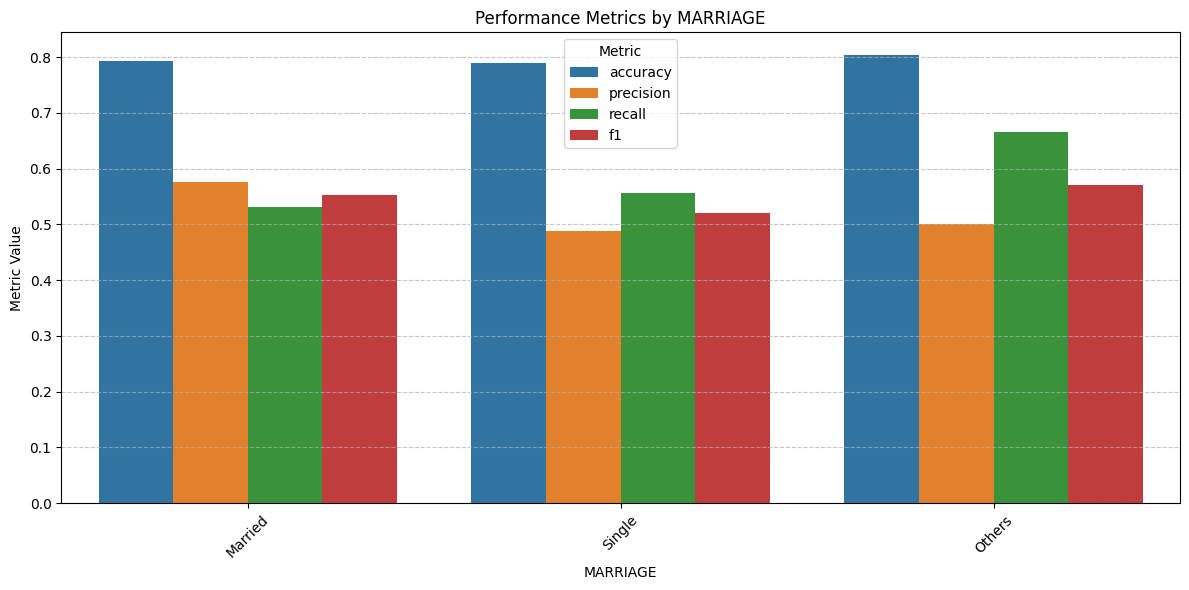


 Detected potential bias in EDUCATION, applying mitigation...

--- Bias Mitigation for 'EDUCATION' using Reweighing ---
X_train_selected shape: (21000, 30)
X_val_selected shape: (4500, 30)
X_test_selected shape: (4500, 30)
y_train shape: (21000,)
y_val shape: (4500,)
y_test shape: (4500,)
df_train_original shape: (21000, 49)
Train sensitive shape: (21000, 1)
Val sensitive shape: (4500, 1)
Test sensitive shape: (4500, 1)
Training XGBoost model with reweighing weights...
X_train_features shape: (21000, 30)
X_val_features shape: (4500, 30)

Evaluating reweighed model...

Fairness Metrics After Reweighing (EDUCATION):
Statistical Parity Difference: nan
Disparate Impact: nan

Performance Metrics:
Accuracy: 0.8167
Precision: 0.6660
Recall: 0.3444
F1 Score: 0.4540


c:\Users\Asus\AppData\Local\Programs\Python\Python313\Lib\site-packages\aif360\metrics\classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)


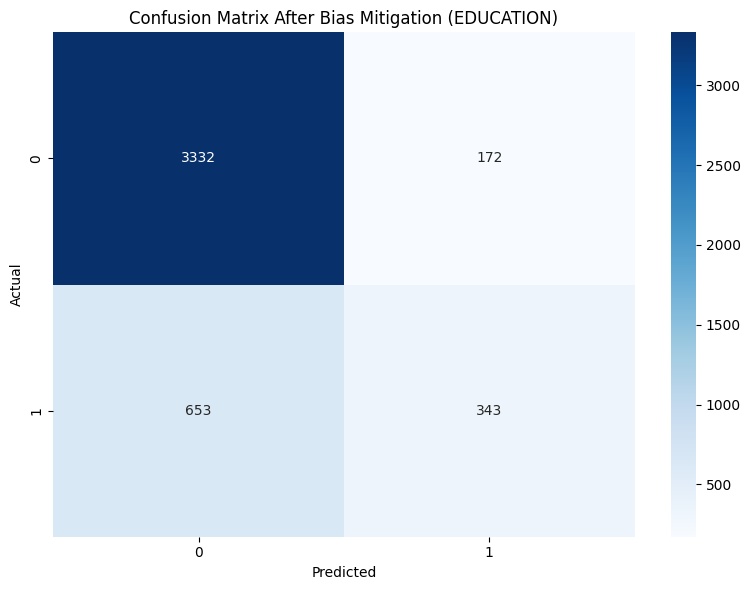


Re-evaluating fairness after mitigation...

--- Model Fairness Analysis ---

Fairness Analysis for SEX:
  group_name  count  accuracy  precision    recall  selection_rate
0       Male   1766  0.783692   0.661765  0.301339        0.115515
1     Female   2734  0.837966   0.668810  0.379562        0.113753

Fairness Metrics for SEX:
  Statistical Parity Difference: 0.0018 (closer to 0 is better)
  Disparate Impact: 0.9847 (closer to 1 is better)


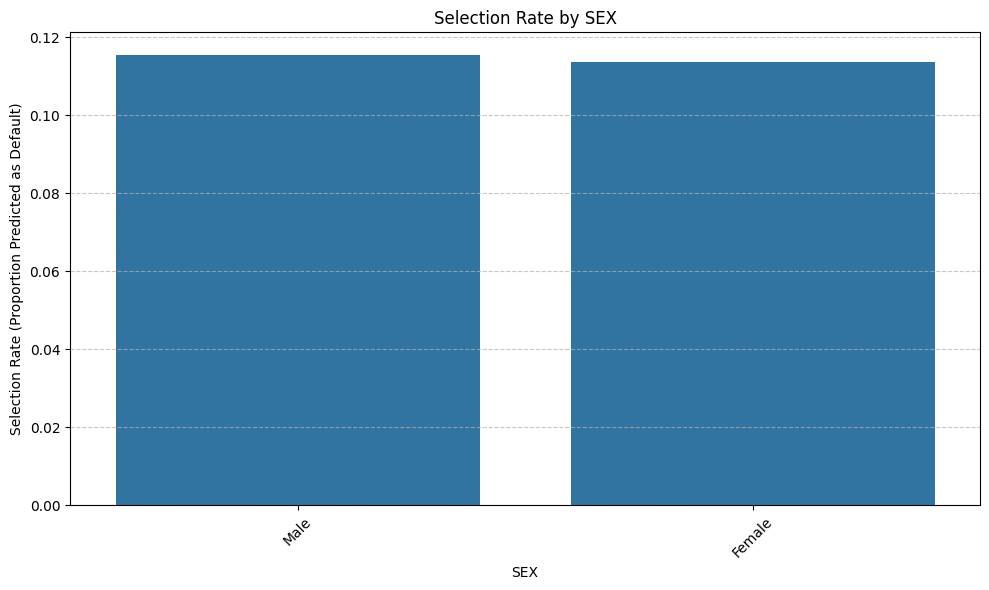

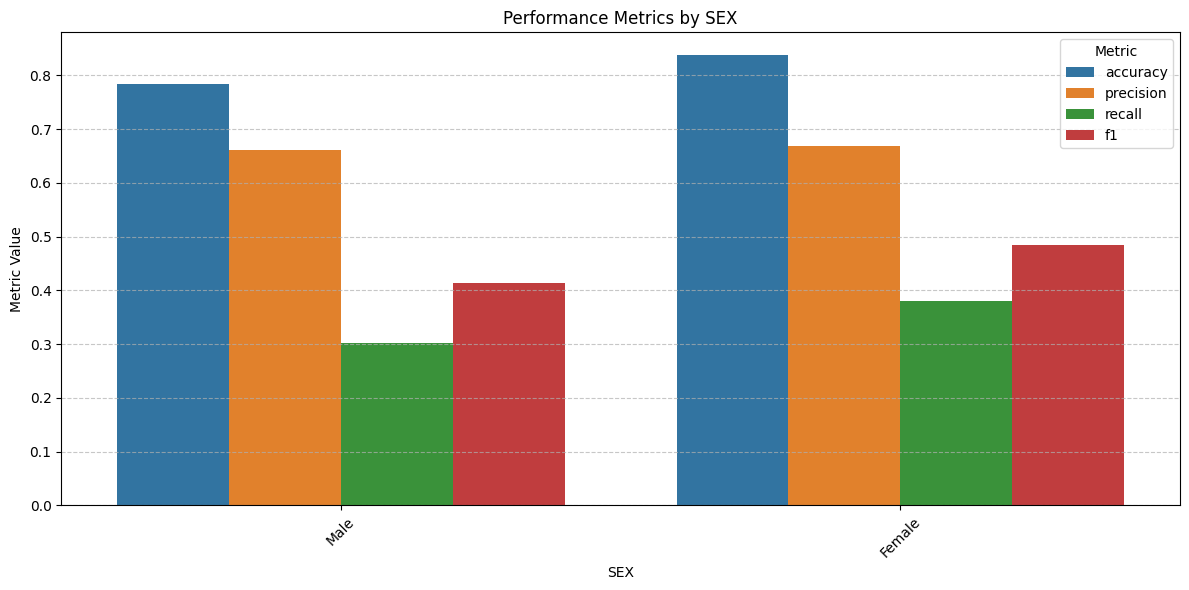


Fairness Analysis for EDUCATION:
    group_name  count  accuracy  precision    recall  selection_rate
0     Graduate   1580  0.823418   0.645390  0.284375        0.089241
1   University   2086  0.818792   0.684015  0.385744        0.128955
2  High School    766  0.783290   0.647619  0.345178        0.137076
3    Group 3.5     68  0.970588   0.000000  0.000000        0.000000

Fairness Metrics for EDUCATION:
  Statistical Parity Difference: 0.1371 (closer to 0 is better)
  Disparate Impact: 0.0000 (closer to 1 is better)


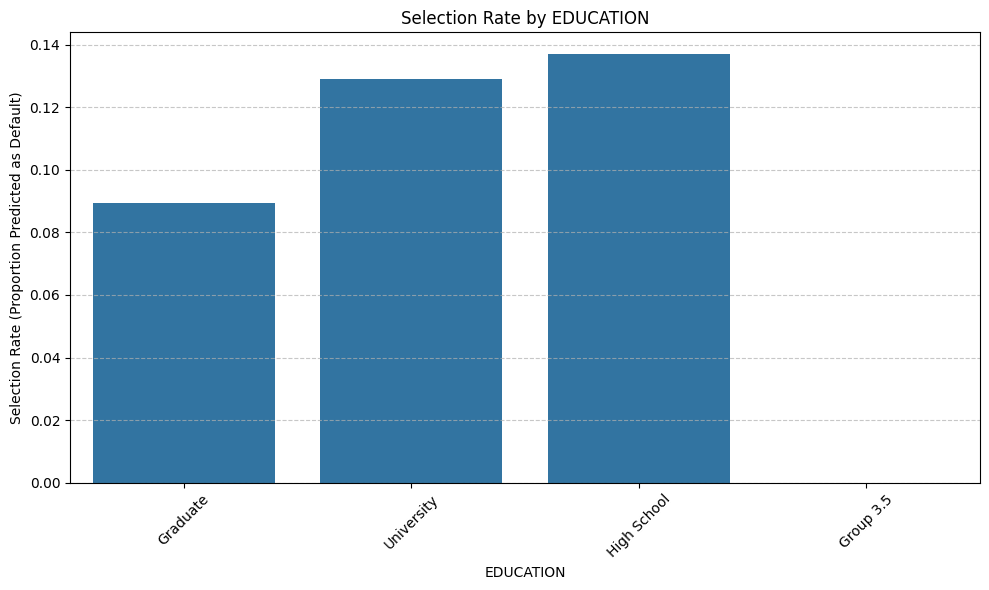

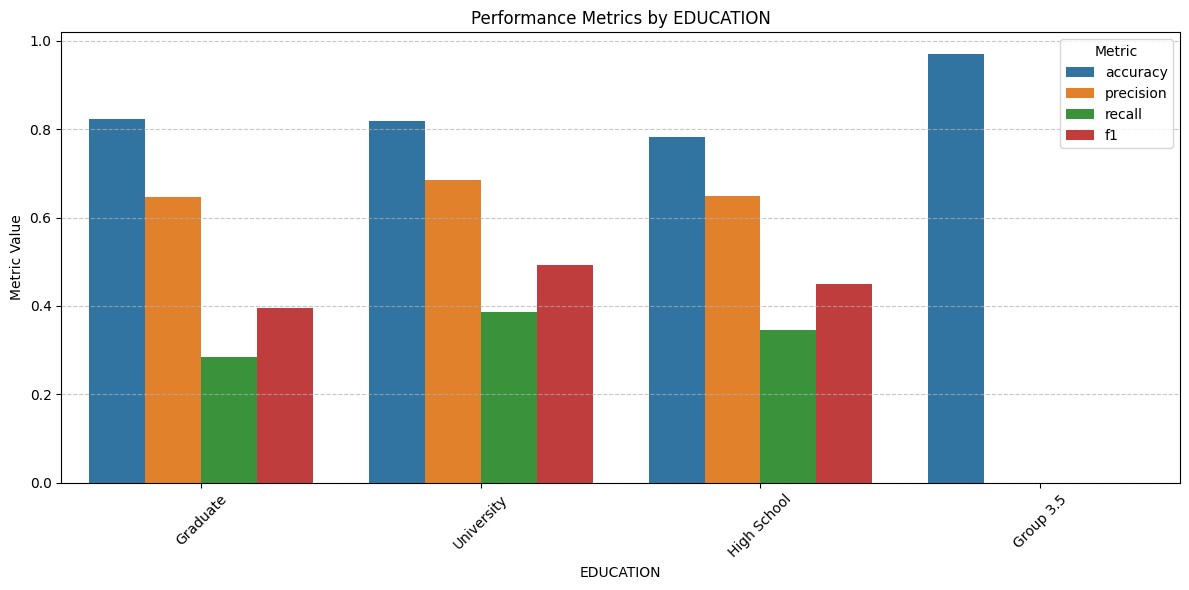


Fairness Analysis for MARRIAGE:
  Group MARRIAGE=0 has fewer than 10 samples, skipping.
  group_name  count  accuracy  precision    recall  selection_rate
0    Married   2063  0.810955   0.734783  0.339357        0.111488
1     Single   2383  0.821653   0.615942  0.347648        0.115820
2     Others     46  0.847826   0.666667  0.444444        0.130435

Fairness Metrics for MARRIAGE:
  Statistical Parity Difference: 0.0189 (closer to 0 is better)
  Disparate Impact: 0.8547 (closer to 1 is better)


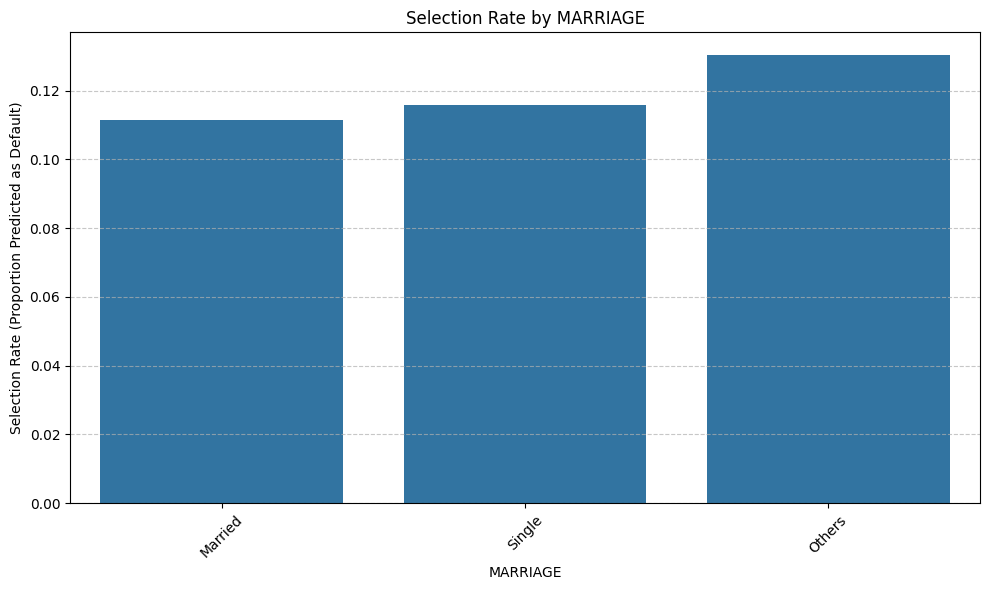

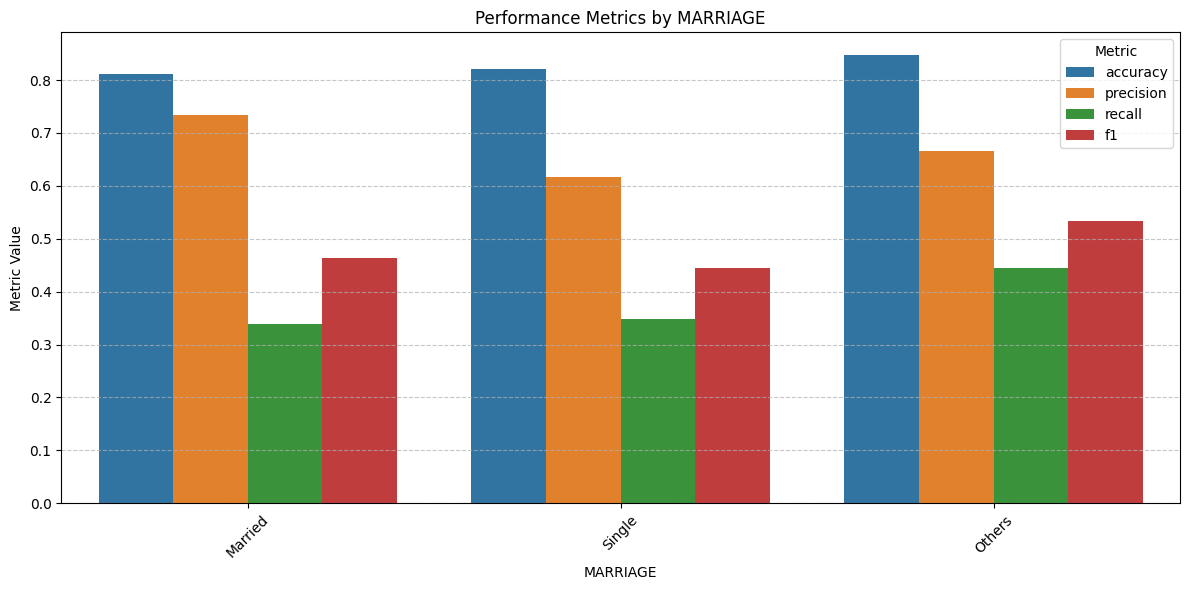


--- SHAP Analysis for Model Interpretability ---


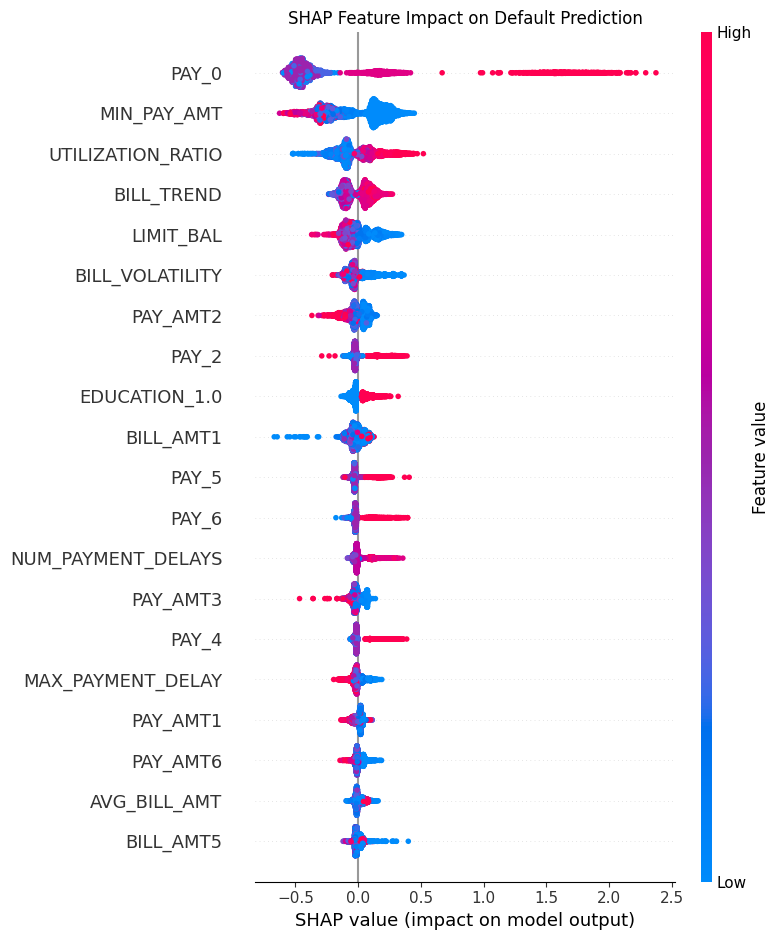

SHAP summary plot saved as 'shap_plots/shap_summary_plot.png'


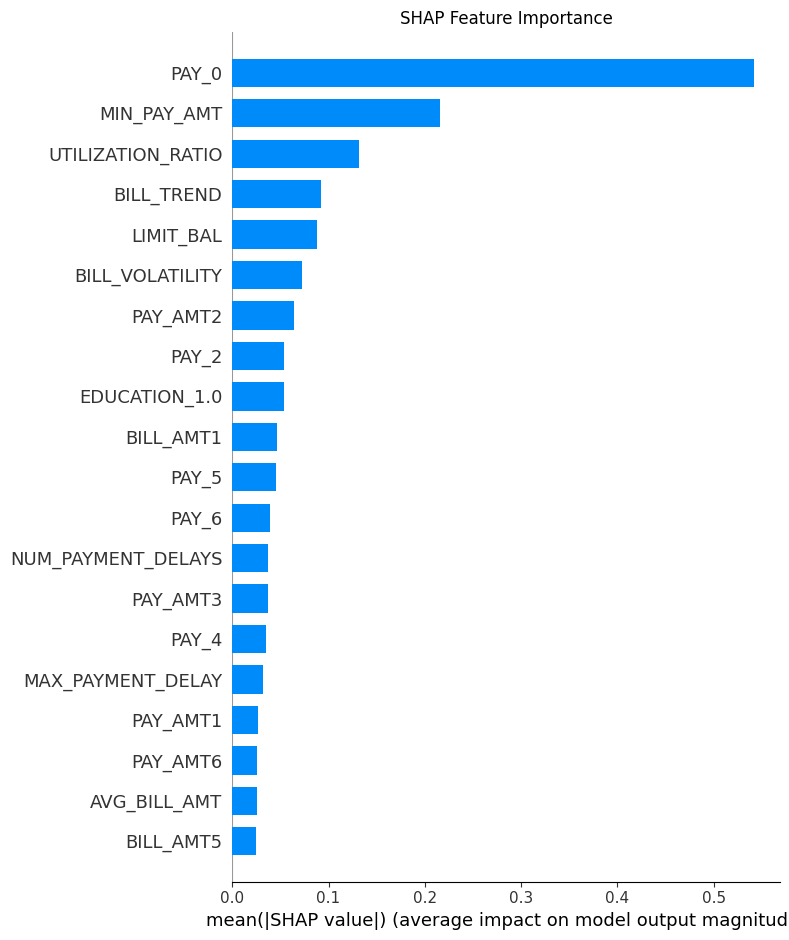

SHAP feature importance bar plot saved as 'shap_plots/shap_importance_bar.png'


<Figure size 1200x300 with 0 Axes>

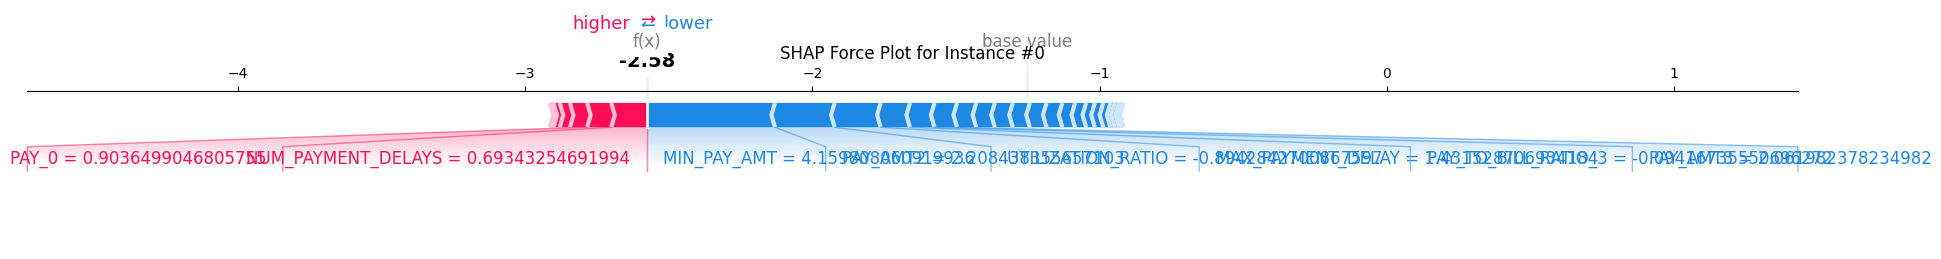

SHAP force plot saved as 'shap_plots/shap_force_plot.png'


<Figure size 1000x600 with 0 Axes>

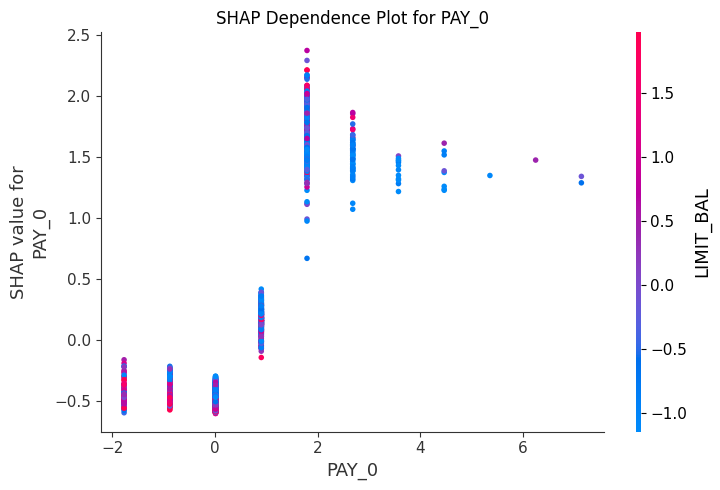

SHAP dependence plot for PAY_0 saved as 'shap_plots/shap_dependence_plot.png'


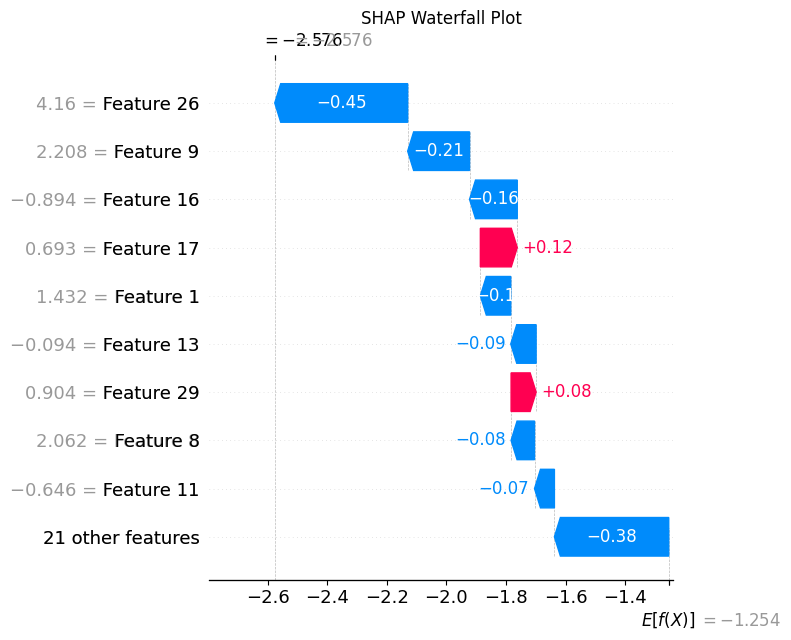

SHAP waterfall plot saved as 'shap_plots/shap_waterfall_plot.png'


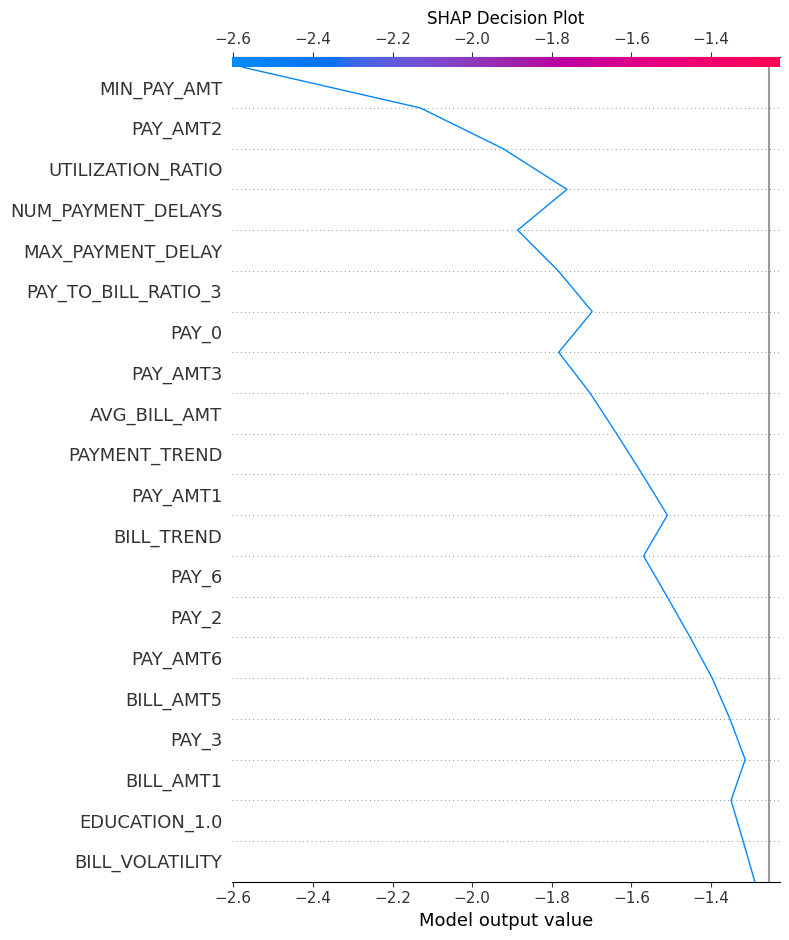

SHAP decision plot saved as 'shap_plots/shap_decision_plot.png'


In [33]:
from sklearn.metrics import precision_recall_curve
def main():
    # Handle outliers
    df_cleaned = handle_outliers_iqr(df, target_column='default payment next month')
    
    # Feature engineering
    df_fe = feature_engineering(df_cleaned)
    
    # Preprocess data
    X_train, X_val, X_test, y_train, y_val, y_test, preprocessor, feature_names = preprocess_data(df_fe)
    
    # Keep original dataframes for fairness analysis
    train_indices = y_train.index
    val_indices = y_val.index
    test_indices = y_test.index
    
    df_train_original = df_fe.loc[train_indices]
    df_val_original = df_fe.loc[val_indices]
    df_test_original = df_fe.loc[test_indices]
    
    # Feature selection
    X_train_selected, X_val_selected, X_test_selected, selected_feature_names = select_features(
        X_train, y_train, X_val, X_test, feature_names, selection_method='model_based'
    )
    
    # Handle class imbalance
    X_train_balanced, y_train_balanced = handle_class_imbalance(X_train_selected, y_train, method='smote')
    
    # Train model
    model = train_xgboost_model(X_train_balanced, y_train_balanced, X_val_selected, y_val)
    
    # Evaluate model
    evaluation_results = evaluate_model(
        model, X_train_balanced, y_train_balanced, 
        X_val_selected, y_val, 
        X_test_selected, y_test
    )
    
    # Find optimal threshold
    optimal_threshold, val_thresholds, test_thresholds = threshold_analysis(
        model, X_val_selected, y_val, X_test_selected, y_test
    )
    
    # Run SHAP analysis for model interpretability
    explainer, shap_values = shap_analysis(model, X_train_balanced, X_test_selected, selected_feature_names)
    
    # Run fairness analysis
    fairness_results = fairness_analysis(model, X_test_selected, y_test, df_test_original)
    
    # Check if we need bias mitigation (e.g., if disparate impact is below 0.8 or above 1.25)
    need_mitigation = False
    sensitive_attr_to_mitigate = None
    
    # This is a simplified check - you might want more sophisticated criteria
    for attr, metrics_df in fairness_results.items():
        if len(metrics_df) >= 2:
            selection_rates = metrics_df['selection_rate'].values
            max_rate = np.max(selection_rates)
            min_rate = np.min(selection_rates)
            
            disparate_impact = min_rate / max_rate if max_rate > 0 else 1.0
            
            if disparate_impact < 0.8 or disparate_impact > 1.25:
                need_mitigation = True
                sensitive_attr_to_mitigate = attr
                break
    
    # Apply bias mitigation if needed
    if need_mitigation and sensitive_attr_to_mitigate:
        print(f"\n Detected potential bias in {sensitive_attr_to_mitigate}, applying mitigation...")
        mitigated_model = mitigate_bias(
            X_train_selected, y_train,
            X_val_selected, y_val,
            X_test_selected, y_test,
            df_train_original,
            sensitive_attr=sensitive_attr_to_mitigate
        )
        
        # Re-evaluate fairness with mitigated model
        print("\nRe-evaluating fairness after mitigation...")
        mitigated_fairness = fairness_analysis(mitigated_model, X_test_selected, y_test, df_test_original)
        
        # Run SHAP on mitigated model
        mitigated_explainer, mitigated_shap = shap_analysis(
            mitigated_model, X_train_balanced, X_test_selected, selected_feature_names
        )
        
        return mitigated_model, mitigated_explainer, mitigated_shap, mitigated_fairness
    else:
        print("\n No significant bias detected that requires mitigation.")
    
    print("\n Analysis complete! Check the generated plots for SHAP and fairness insights.")
    
    return model, explainer, shap_values, fairness_results

# Run the main function
if __name__ == "__main__":
    model, explainer, shap_values, fairness_results = main()